In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from minisom import MiniSom
import scipy
import netCDF4
from datetime import datetime
import time
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from __future__ import print_function
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

In [3]:
rh = xr.open_dataset('rh.nc')
etopo = xr.open_dataset('ETOPO1_Bed_g_gmt4.grd')
topo = np.flip(etopo.z.sel(x=slice(100,180),y=slice(0,50.1))[0::60,::60], 0)

In [4]:
ds=xr.open_dataset('storm_relative_data.nc')

ds['u_200'] = np.flip(ds['u_200'], 1)
ds['v_200'] = np.flip(ds['v_200'], 1)
ds['u_500'] = np.flip(ds['u_500'], 1)
ds['v_500'] = np.flip(ds['v_500'], 1)
ds['u_850'] = np.flip(ds['u_850'], 1)
ds['v_850'] = np.flip(ds['v_850'], 1)
ds['gh_200'] = np.flip(ds['gh_200'], 1)
ds['gh_500'] = np.flip(ds['gh_500'], 1)
ds['gh_850'] = np.flip(ds['gh_850'], 1)
ds['t_850'] = np.flip(ds['t_850'], 1)
ds['t_1000'] = np.flip(ds['t_1000'], 1)

ds = ds.where(ds.time!=ds.time[1978], drop=True)

In [5]:
ds2 = xr.open_dataset('fixed_range_data.nc')

ds2['fixed_u_200'] = np.flip(ds2['fixed_u_200'], 1)
ds2['fixed_v_200'] = np.flip(ds2['fixed_v_200'], 1)
ds2['fixed_u_500'] = np.flip(ds2['fixed_u_500'], 1)
ds2['fixed_v_500'] = np.flip(ds2['fixed_v_500'], 1)
ds2['fixed_u_850'] = np.flip(ds2['fixed_u_850'], 1)
ds2['fixed_v_850'] = np.flip(ds2['fixed_v_850'], 1)
ds2['fixed_gh_200'] = np.flip(ds2['fixed_gh_200'], 1)
ds2['fixed_gh_500'] = np.flip(ds2['fixed_gh_500'], 1)
ds2['fixed_gh_850'] = np.flip(ds2['fixed_gh_850'], 1)
ds2['fixed_t_850'] = np.flip(ds2['fixed_t_850'], 1)
ds2['fixed_t_1000'] = np.flip(ds2['fixed_t_1000'], 1)

ds2 = ds2.where(ds2.time!=ds2.time[1975], drop=True)

In [6]:
ibtracs_data = xr.open_dataset('IBTrACS.WP.v04r00.nc')
storm_id = ibtracs_data.storm[(ibtracs_data.time[:,0].dt.year > 2009)&(ibtracs_data.time[:,0].dt.year < 2020)]
this_storm = ibtracs_data.sel(storm=storm_id)
storm_time = this_storm.time
storm_time_initial = storm_time[:,0]

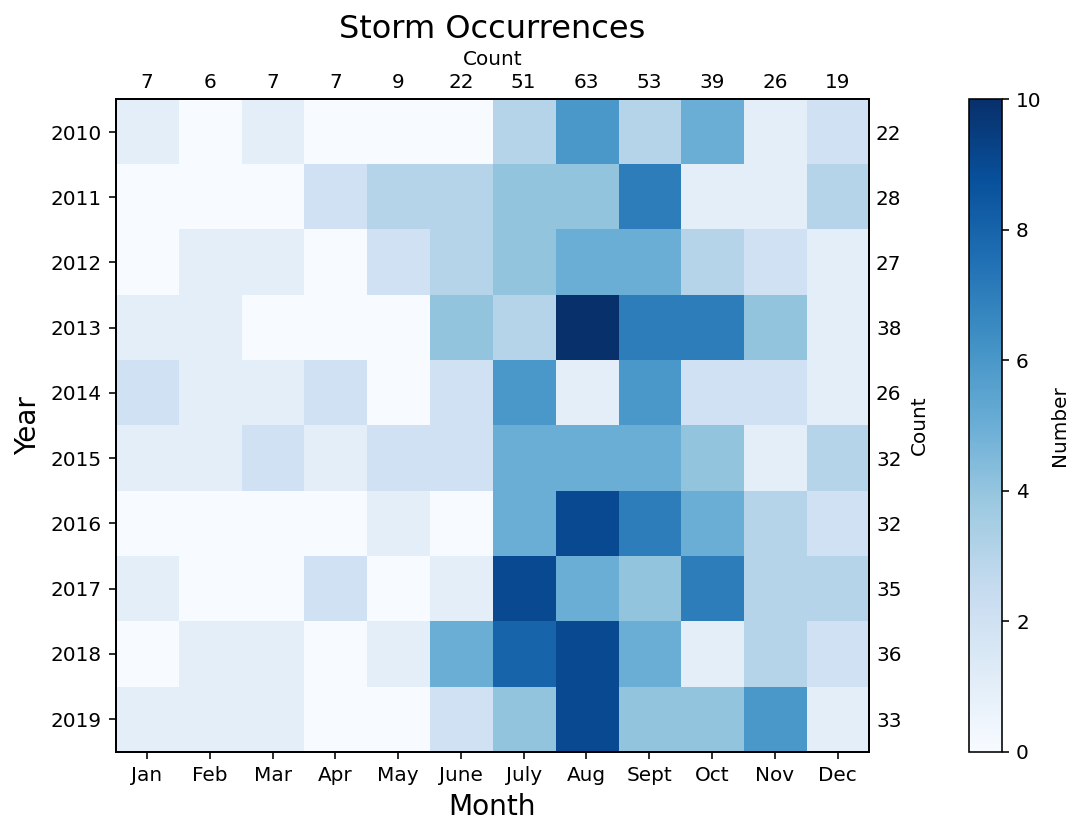

In [8]:
hi=[]
np_month = np.arange(1,13)
for year in range(10):
    for month in np_month:
        hi.append(np.sum( storm_time_initial.dt.month[storm_time_initial.dt.year.values==2010+year].values == month ))
matshow = np.reshape(hi,(10,12))
matshow = np.flip(matshow, 0)

fig, ax = plt.subplots(figsize=(9,6))
im = ax.matshow(np.flip(matshow, 0),interpolation=None,aspect='auto',cmap='Blues')

ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Month',fontsize=14)
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", 
          "Aug", "Sept", "Oct", "Nov", "Dec"]
plt.xticks(np.arange(0,12),months)

ax.set_ylabel('Year',fontsize=14)
years=np.arange(2010,2020)
plt.yticks(np.arange(0,10),years)

ax2 = ax.twiny()
ax2.set_xlabel("Count")
ax2.set_xlim(0, 12)
ax2.set_xticks(np.linspace(0.5,11.5,12))
ax2.set_xticklabels(np.sum(matshow,axis=0))
ax2.xaxis.set_tick_params(length=0,labelbottom=False)
ax3 = ax.twinx()
ax3.set_ylabel("Count")
ax3.set_ylim(0,10)
ax3.set_yticks(np.linspace(0.5,9.5,10))
ax3.set_yticklabels(np.sum(matshow,axis=1))
ax3.yaxis.set_tick_params(length=0,labelbottom=False)

fig.colorbar(im, ax=ax, label="Number",pad=0.1)
plt.title('Storm Occurrences',fontsize=16)
plt.show(ax)

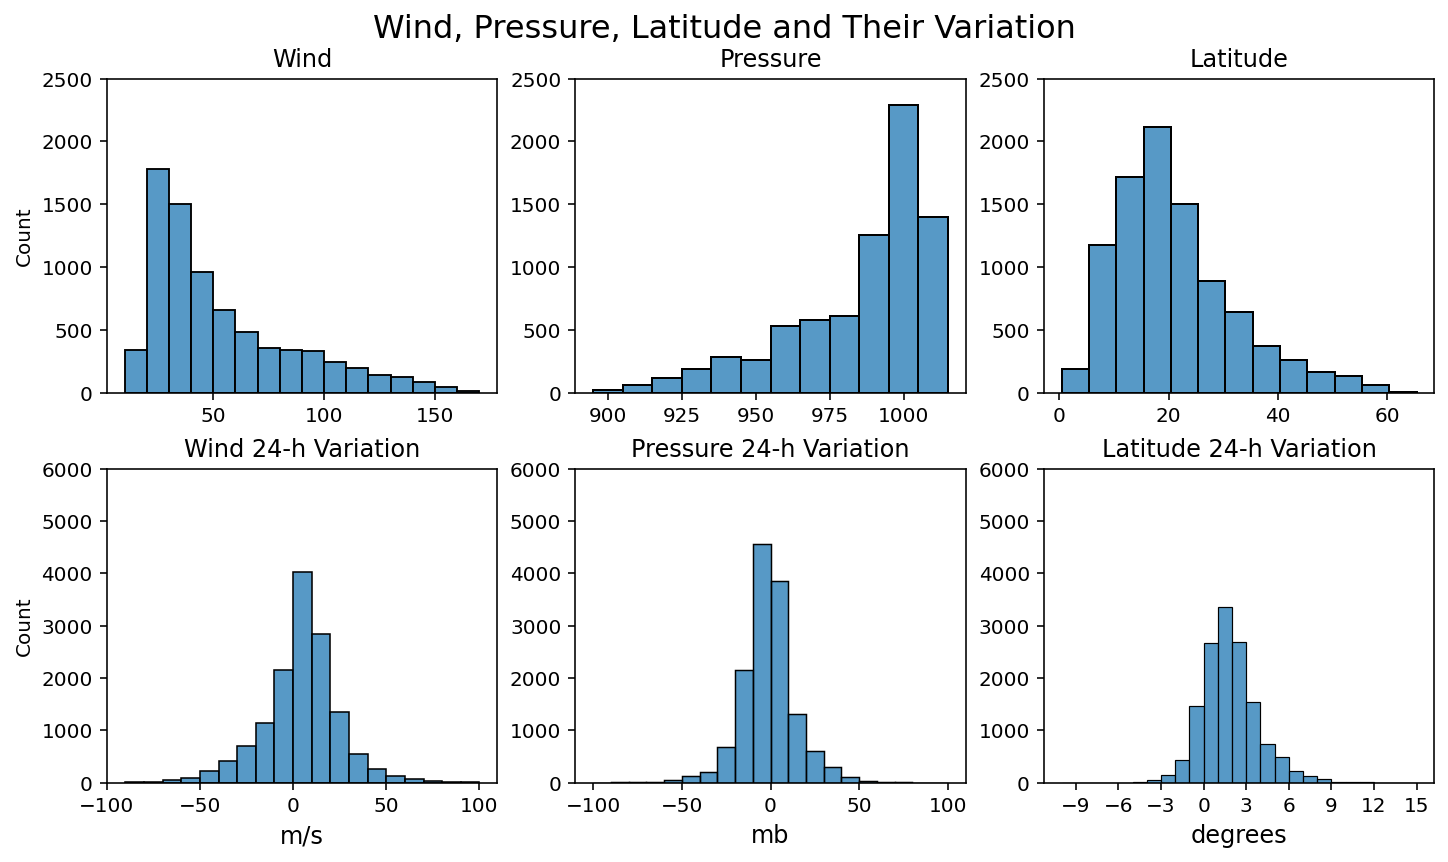

In [112]:
wind_change24 = np.array(pd.read_csv('wind_change24.csv',header=None))
pres_change24 = np.array(pd.read_csv('pres_change24.csv',header=None))
lat_change24 = np.array(pd.read_csv('lat_change24.csv',header=None))
## Computation
# wind_change24 = np.empty((309,120))
# pres_change24 = np.empty((309,120))
# lat_change24 = np.empty((309,120))
# wind_change24[:] = np.NaN
# pres_change24[:] = np.NaN
# lat_change24[:] = np.NaN
# for i in this_storm.storm:
#     for j in range(120):
#         wind_change24[i,j] = this_storm.usa_wind[i,j+8]-this_storm.usa_wind[i,j]
#         pres_change24[i,j] = this_storm.usa_pres[i,j+8]-this_storm.usa_pres[i,j]
#         lat_change24[i,j] = this_storm.usa_lat[i,j+8]-this_storm.usa_lat[i,j]

# np.savetxt("wind_change24.csv", wind_change24, delimiter=",")
# np.savetxt("pres_change24.csv", pres_change24, delimiter=",")
# np.savetxt("lat_change24.csv", lat_change24, delimiter=",")

fig, ax = plt.subplots(2, 3, figsize=(10,6))#, constrained_layout=True

ax = ax.ravel()  
sns.histplot(ds.usa_wind, ax=ax[0], binwidth=10)
ax[0].set_title('Wind')
#    ax[0].set_xlabel('m/s')
ax[0].set_yticks(np.arange(0,2501,500))

sns.histplot(ds.usa_pres, ax=ax[1], binwidth=10)
ax[1].set_title('Pressure')
ax[1].set(ylabel='')
ax[1].set_yticks(np.arange(0,2501,500))

sns.histplot(ds.latitude, ax=ax[2], binwidth=5)
ax[2].set_title('Latitude')
ax[2].set(ylabel='')
ax[2].set_yticks(np.arange(0,2501,500))

sns.histplot(wind_change24[~np.isnan(wind_change24)], ax=ax[3], binwidth=10)
ax[3].set_title('Wind 24-h Variation')
ax[3].set_xlabel('m/s', fontsize=12)
ax[3].set_xticks(np.arange(-100,101,50))
ax[3].set_yticks(np.arange(0,6001,1000))

sns.histplot(pres_change24[~np.isnan(pres_change24)], ax=ax[4], bins=np.arange(-100,101,10))
ax[4].set_title('Pressure 24-h Variation')
ax[4].set_xlabel('mb', fontsize=12)
ax[4].set_xticks(np.arange(-100,101,50))
ax[4].set_yticks(np.arange(0,6001,1000))
ax[4].set(ylabel='')

sns.histplot(lat_change24[~np.isnan(lat_change24)], ax=ax[5], bins=np.arange(-10,16,1))
ax[5].set_title('Latitude 24-h Variation')
ax[5].set_xlabel('degrees', fontsize=12) 
ax[5].set_yticks(np.arange(0,6001,1000))
ax[5].set_xticks(np.arange(-9,16,3))
ax[5].set(ylabel='')

fig.suptitle('Wind, Pressure, Latitude and Their Variation',fontsize=16)
fig.tight_layout(pad=0.5)
plt.show()

In [10]:
### NORMALIZATION
u_shear = ds.u_200-ds.u_850
v_shear = ds.v_200-ds.v_850
u_shear_reshape = np.reshape(np.array(u_shear),(9213,3721))
v_shear_reshape = np.reshape(np.array(v_shear),(9213,3721))
total_shear_reshape = np.sqrt(u_shear_reshape**2 + v_shear_reshape**2)

# Z-score normalization
z_norm_u_shear = (u_shear_reshape-np.mean(u_shear_reshape))/np.std(u_shear_reshape)
z_norm_v_shear = (v_shear_reshape-np.mean(v_shear_reshape))/np.std(v_shear_reshape)
z_norm_total_shear = (total_shear_reshape-np.mean(total_shear_reshape))/np.std(total_shear_reshape)

In [11]:
#total_shear_train = total_shear_reshape[:,22:39,22:39]
u_shear_train = np.reshape(np.array(u_shear[:,22:39,22:39]), (9213,17*17))
v_shear_train = np.reshape(np.array(v_shear[:,22:39,22:39]), (9213,17*17))
total_shear_train = np.sqrt(u_shear_train**2 + v_shear_train**2)

u_shear_train_norm = (u_shear_train-np.mean(u_shear_train))/np.std(u_shear_train)
v_shear_train_norm = (v_shear_train-np.mean(v_shear_train))/np.std(v_shear_train)
total_shear_train_norm = (total_shear_train-np.mean(total_shear_train))/np.std(total_shear_train)

In [12]:
### TRAINING SOM

nrows = 3
ncols = 3
nodes = nrows*ncols
som = MiniSom(nrows, ncols, 17*17, sigma=1.,
              learning_rate=0.2, neighborhood_function='gaussian')  # 3x3 = 9 final colors
som.random_weights_init(total_shear_train_norm)
starting_weights = som.get_weights().copy()  # saving the starting weights
#som.train(z_norm_u_shear, 10000, random_order=True)#, verbose=True)
som.train_batch(total_shear_train_norm, 10000, verbose=True)

print('quantization...')
qnt = som.quantization(total_shear_train_norm)  # quantize each pixels of the image
print('building new image...')
#clustered = np.zeros((51,100))
#print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

som_shape = (nrows, ncols)
winner_coordinates = np.array([som.winner(x) for x in total_shear_train_norm]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape) # give each grid a cluster_index

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(total_shear_train_norm, cluster_index))

 [   736 / 10000 ]   7% - 0:00:02 left 

 [  1315 / 10000 ]  13% - 0:00:02 left 

 [  1881 / 10000 ]  19% - 0:00:02 left 

 [  2420 / 10000 ]  24% - 0:00:02 left 

 [  3139 / 10000 ]  31% - 0:00:02 left 

 [  3862 / 10000 ]  39% - 0:00:01 left 

 [  4493 / 10000 ]  45% - 0:00:01 left 

 [  5058 / 10000 ]  51% - 0:00:01 left 

 [  5627 / 10000 ]  56% - 0:00:01 left 

 [  6196 / 10000 ]  62% - 0:00:01 left 

 [  6766 / 10000 ]  68% - 0:00:01 left 

 [  7336 / 10000 ]  73% - 0:00:00 left 

 [  7906 / 10000 ]  79% - 0:00:00 left 

 [  8475 / 10000 ]  85% - 0:00:00 left 

 [  9044 / 10000 ]  90% - 0:00:00 left 

 [  9614 / 10000 ]  96% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 


 quantization error: 11.490991879970045
quantization...
building new image...
Silhouette Coefficient: 0.074


In [13]:
som.quantization_error(total_shear_train_norm)
#som.quantization_error(z_norm_u_shear[0])
np.power(np.linalg.norm(total_shear_train_norm[0] - qnt[0]).mean(),2)/17/17
#(z_norm_u_shear[0] - qnt[0]).mean()
#z_norm_u_shear[0].mean()

0.793946419055461

In [14]:
testqnt=np.reshape(qnt, (9213,17,17))
testori=np.reshape(total_shear_train_norm, (9213,17,17))

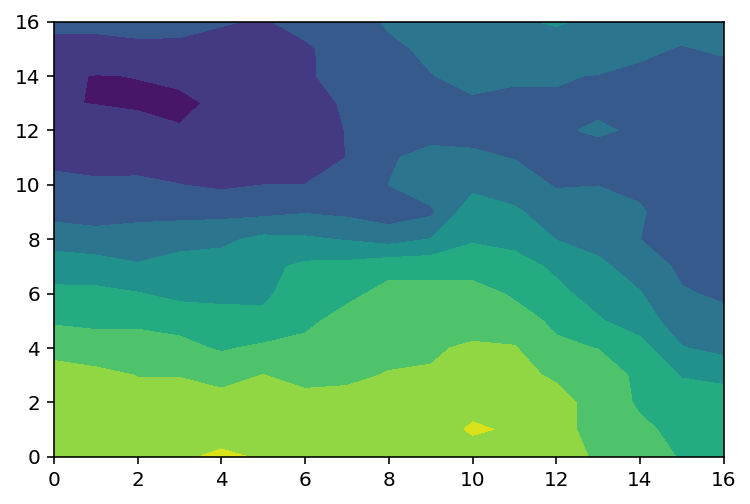

In [15]:
plt.contourf(testqnt[10])

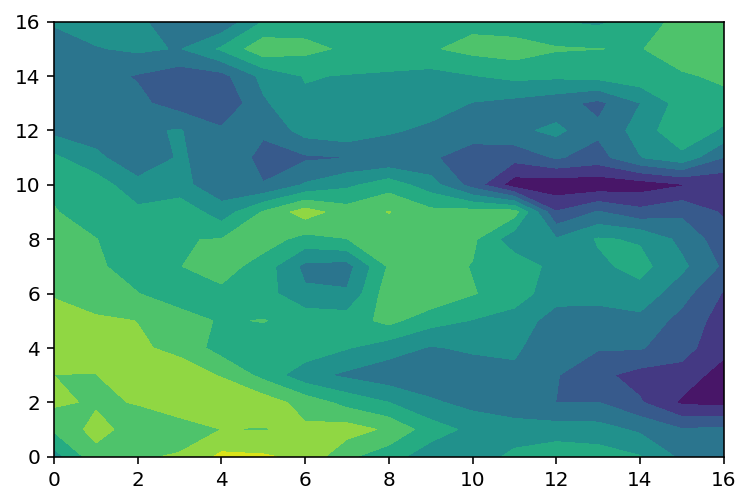

In [16]:
plt.contourf(testori[10])

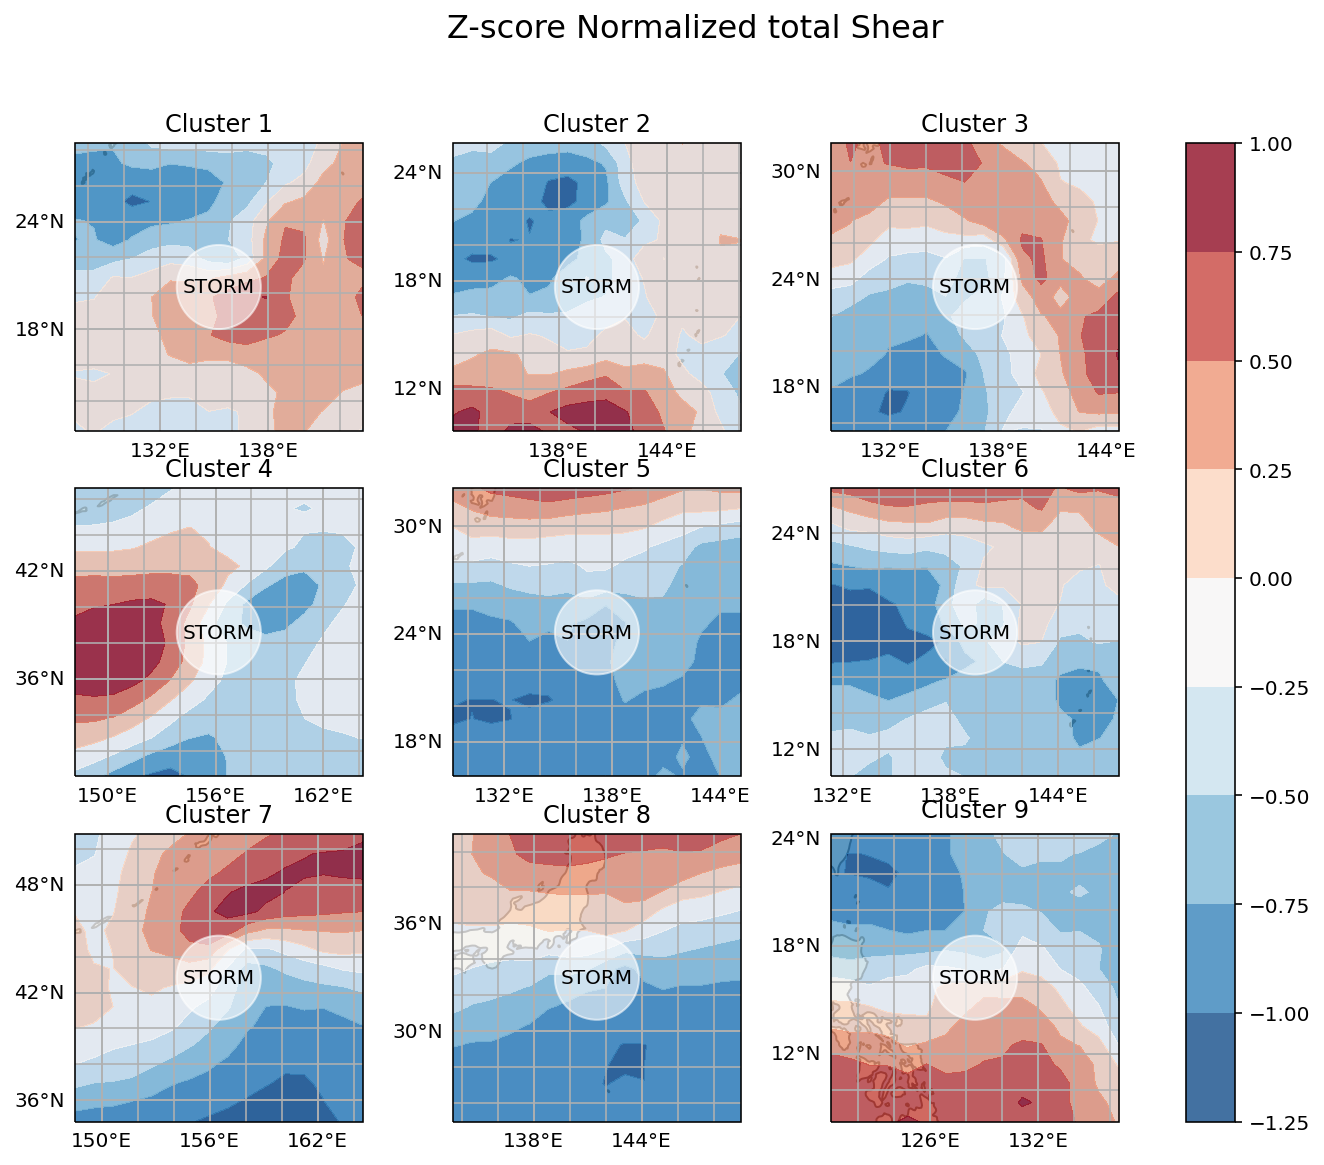

In [106]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
## Calculate the mean lat/lon for each cluster into lats/lons

lats = np.zeros(nodes)
lons = np.zeros(nodes)
for i in range(nodes):
    lats[i] = ds.latitude[cluster_index==i].mean() 
    lons[i] = ds.longitude[cluster_index==i].mean()
    
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-8, lons[i]+9,17)
    lati = np.linspace(lats[i]-8, lats[i]+9,17)

    patterni = np.reshape(np.mean(qnt[cluster_index==i],axis=0),(17,17))

    im = ax[i].contourf(loni-180, lati, patterni, cmap = plt.get_cmap('RdBu_r'),alpha=0.8)
    
    ax[i].text(lons[i]-180, lats[i], "STORM", bbox=dict(boxstyle="circle", color="white", alpha=0.6),
               ha='center', va='center')

    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-188,lons[i]-172)
    ax[i].set_ylim(lats[i]-8,lats[i]+8)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,6), ylocs = np.arange(-90,90,6), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('Z-score Normalized total Shear',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees

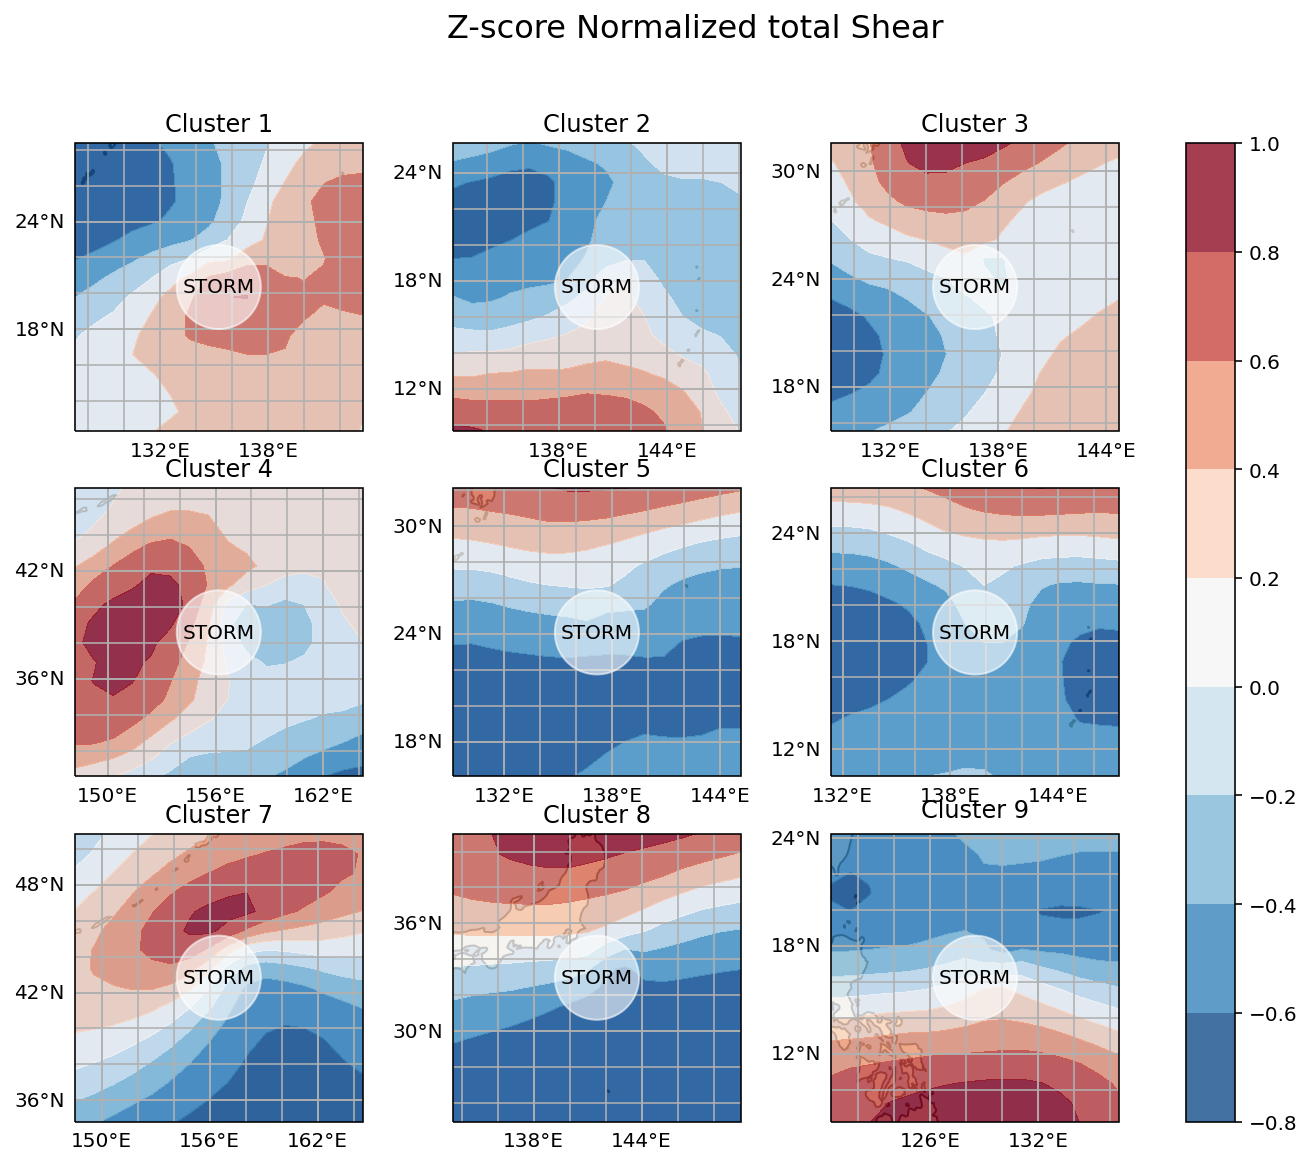

In [107]:
lats = np.zeros(nodes)
lons = np.zeros(nodes)
for i in range(nodes):
    lats[i] = ds.latitude[cluster_index==i].mean() 
    lons[i] = ds.longitude[cluster_index==i].mean()
    
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-8, lons[i]+9,17)
    lati = np.linspace(lats[i]-8, lats[i]+9,17)

    patterni = np.reshape(np.mean(total_shear_train_norm[cluster_index==i],axis=0),(17,17))

    im = ax[i].contourf(loni-180, lati, patterni, cmap = plt.get_cmap('RdBu_r'),alpha=0.8)
    ax[i].text(lons[i]-180, lats[i], "STORM", bbox=dict(boxstyle="circle", color="white", alpha=0.6),
           ha='center', va='center')
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-188,lons[i]-172)
    ax[i].set_ylim(lats[i]-8,lats[i]+8)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,6), ylocs = np.arange(-90,90,6), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('Z-score Normalized total Shear',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees

In [19]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(z_norm_total_shear, cluster_index))

Silhouette Coefficient: -0.012


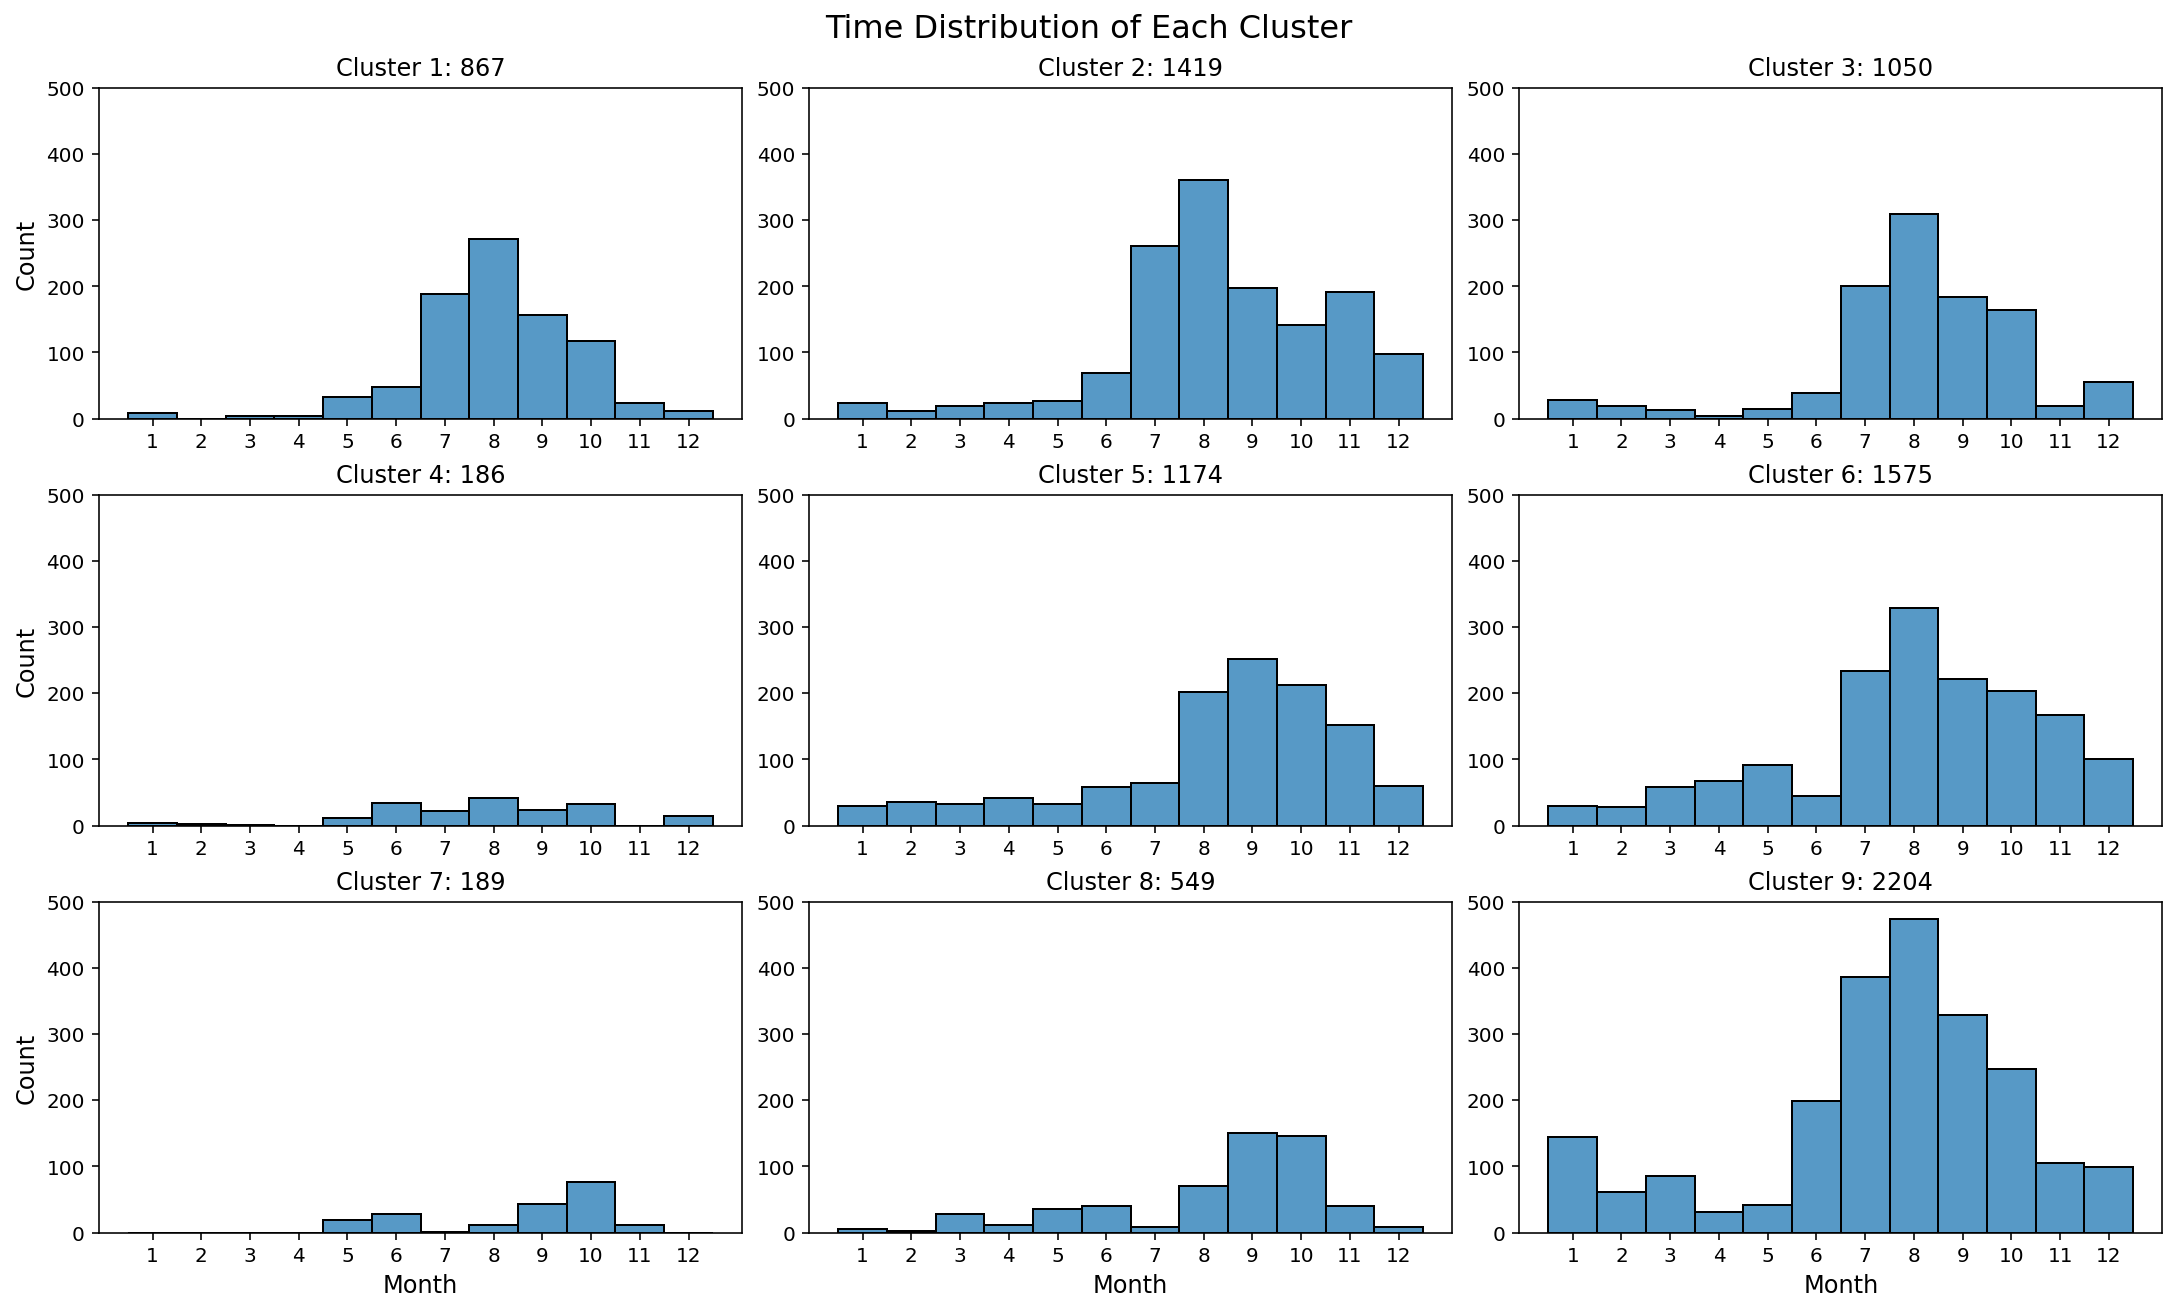

In [111]:
fig, ax = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(ncols*5, nrows*3))

ax = ax.ravel()
for i in range(nodes):    
    plt.setp(ax, xticks=np.arange(1,13))
    sns.histplot(ds.time[cluster_index==i].dt.month,bins=np.arange(13)+0.5, ax=ax[i])
    ax[i].set_title("Cluster "+str(i+1)+': '+str(np.sum(cluster_index==i)))
    if i > 5:
        ax[i].set_xlabel('Month',fontsize=12)
    ax[i].set_yticks(np.arange(0,501,100))
    ax[i].set(ylabel='')
    if i%3 == 0:
        ax[i].set_ylabel('Count', fontsize=12)
        
fig.suptitle('Time Distribution of Each Cluster',fontsize=16)
plt.show()
### 每个cluster总发生数

In [22]:
## Save the cluster index in the order of storms

# np.max(np.sum(~np.isnan(storm_index),axis=1))
storm_index0 = np.empty((309,360))
storm_index0[:] = np.NaN
k=0

for i in this_storm.storm:
    for j in this_storm.date_time:
        if k==9213:
            break;
        if this_storm.time[i,j]-39936 == ds.time[k]:
            storm_index0[i,j] = cluster_index[k]
            
            k+=1
        else:
            continue
storm_index = storm_index0[:,::2]
# np.savetxt("storm_index.csv", storm_index, delimiter=",")

### Lost last 30 storms

/tmp/ipykernel_15020/818499343.py:6: RuntimeWarning: invalid value encountered in long_scalars
  fraction_hist[i].append(np.sum(storm_index[m]==i)/np.sum(~np.isnan(storm_index[m])))


Text(0.5, 0.98, 'The Fraction of Time in Each Cluster Per Storm (without Non-existent)')

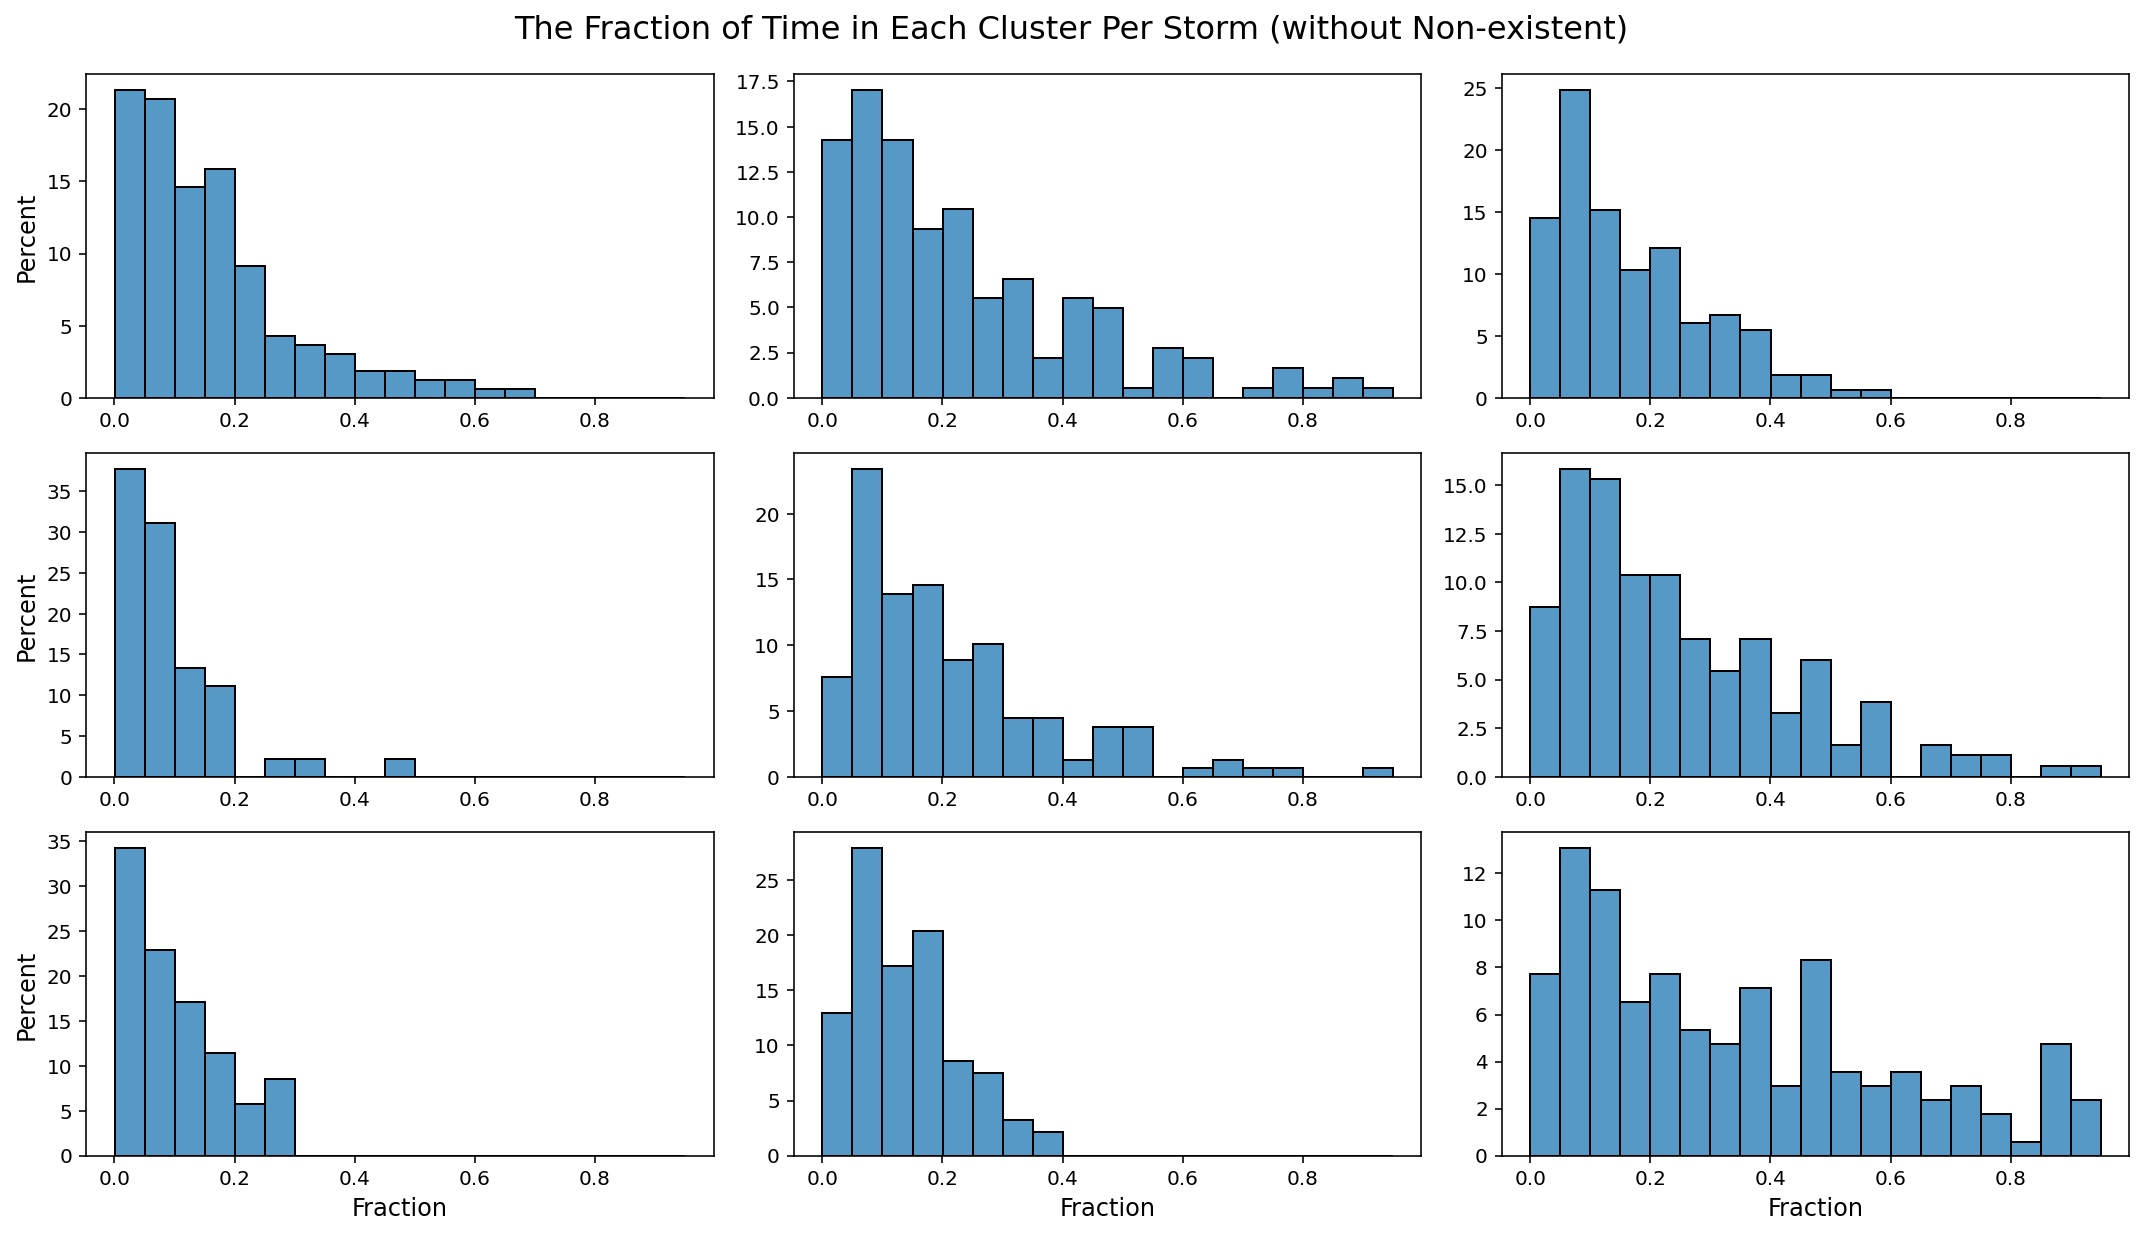

In [89]:
fraction_hist=[[]]
for i in range(nodes-1):
    fraction_hist.append([])
for m in range(len(storm_index[:,0])):
    for i in range(nodes):
        fraction_hist[i].append(np.sum(storm_index[m]==i)/np.sum(~np.isnan(storm_index[m])))
fraction_hist = np.array(fraction_hist)

bins = np.arange(0.0001,1.0001,0.05)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3))
ax = ax.ravel()

for i in range(nodes):    
    sns.histplot(fraction_hist[i], bins = bins, kde = False, ax=ax[i], stat='percent')
#     ax[i].set_yticks(np.arange(0,10))
    if i > 5:
        ax[i].set_xlabel('Fraction', fontsize=12)
    ax[i].set(ylabel='')
    if i%3 == 0:
        ax[i].set_ylabel('Percent', fontsize=12)
        
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.suptitle('The Fraction of Time in Each Cluster Per Storm (without Non-existent)',size=16)

In [24]:
## Calculate the mean lat/lon for each cluster into lats/lons

lats = np.zeros(nodes)
lons = np.zeros(nodes)
for i in range(nodes):
    lats[i] = ds.latitude[cluster_index==i].mean() 
    lons[i] = ds.longitude[cluster_index==i].mean()

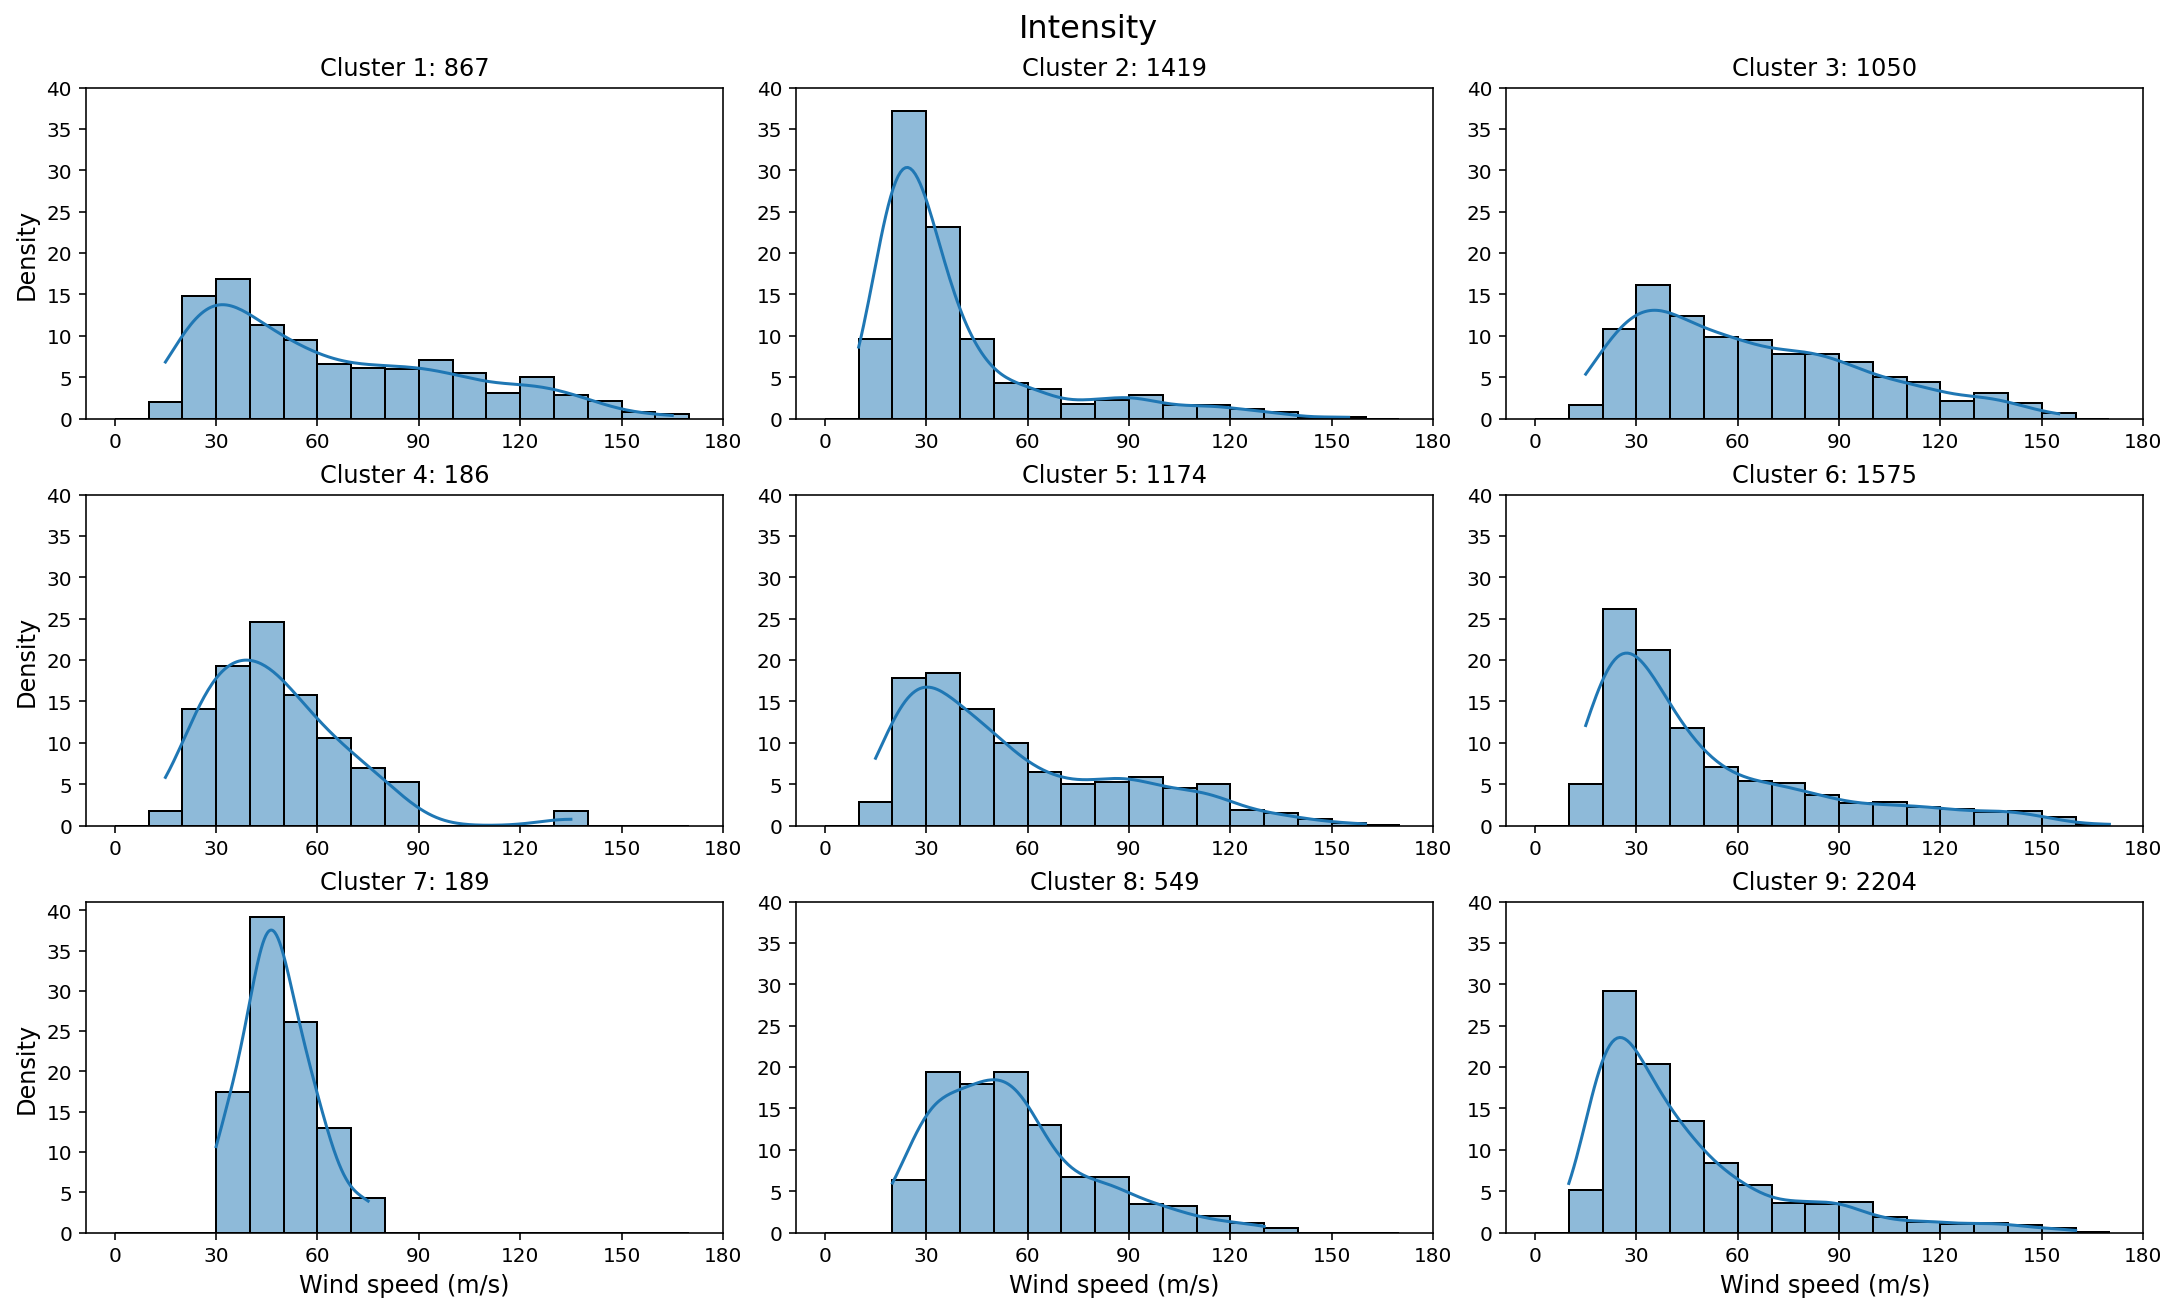

In [119]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(ncols*5,nrows*3))

bins = np.arange(0,180,10)
ax = ax.ravel()
for i in range(nodes):    
    #plt.setp(ax, xticks=np.arange(1,13))
    #ax[i].hist(ds.usa_wind[cluster_index==i], bins=bins)
    sns.histplot(ds.usa_wind[cluster_index==i], bins=bins, kde=True, ax=ax[i], stat='percent')
    ax[i].set_title("Cluster "+str(i+1)+': '+str(np.sum(cluster_index==i)))
    ax[i].set_xticks(np.arange(0,181,30))
    ax[i].set_yticks(np.arange(0,41,5))
    if i > 5:
        ax[i].set_xlabel('Wind speed (m/s)', fontsize=12)
    ax[i].set(ylabel='')
    if i%3 == 0:
        ax[i].set_ylabel('Percent', fontsize=12)
fig.suptitle('Intensity', fontsize=16)
plt.show()

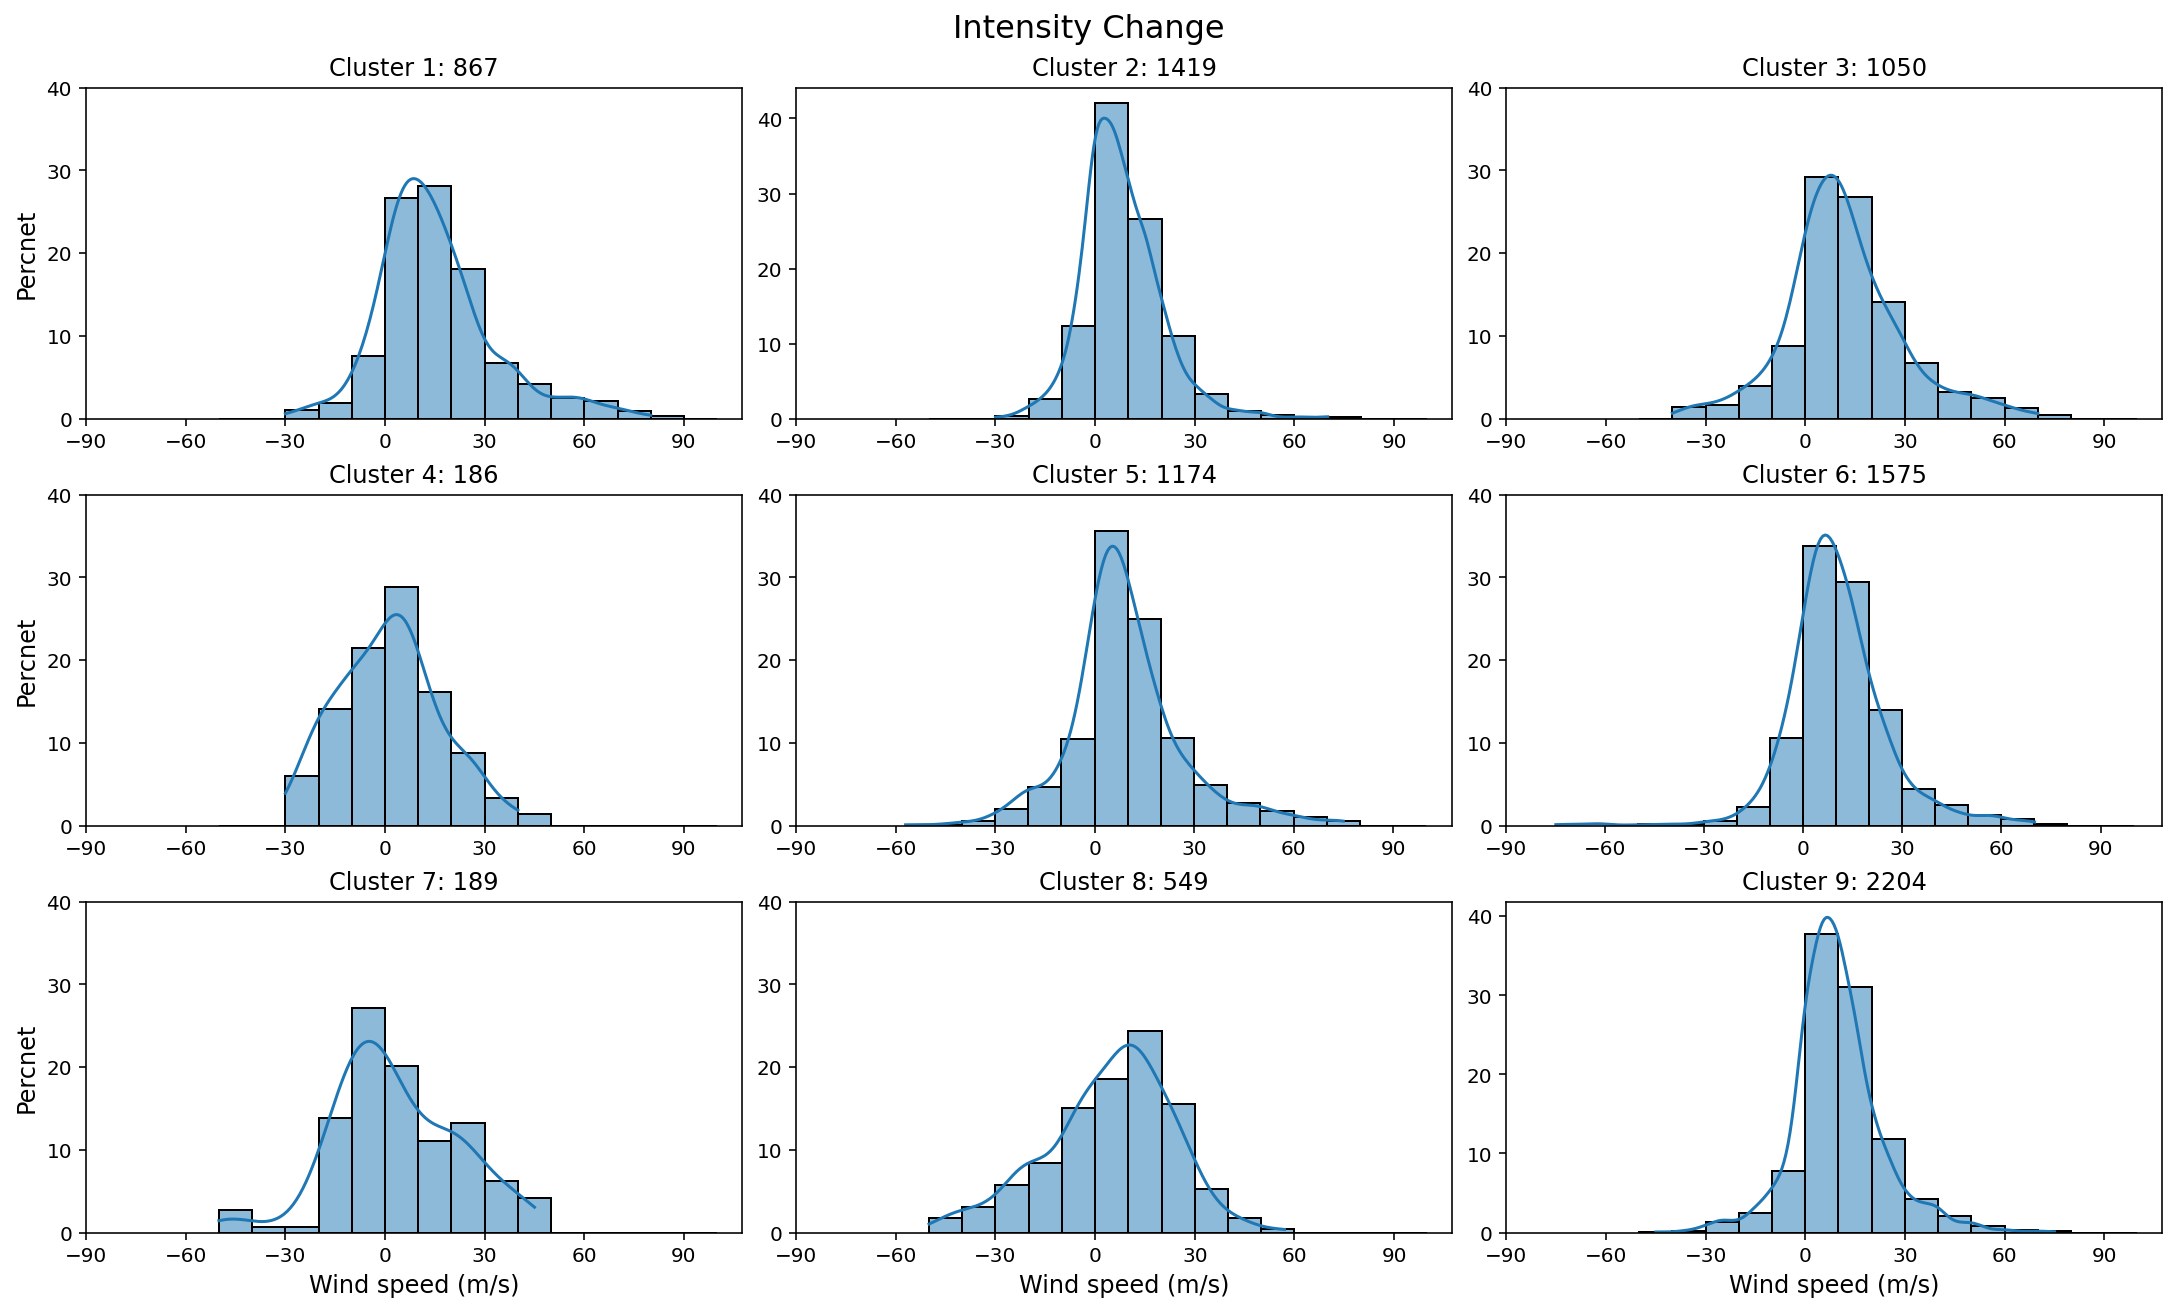

In [121]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(ncols*5,nrows*3))

bins=np.arange(-50, 101, 10)
ax = ax.ravel()
for i in range(nodes):    
    #plt.setp(ax, xticks=np.arange(1,13))
#     ax[i].hist(wind_change24[storm_index==i], bins=bins) ##### fill=False
    sns.histplot(wind_change24[storm_index==i], bins=bins, kde=True, ax=ax[i], stat='percent')
    ax[i].set_title("Cluster "+str(i+1)+': '+str(np.sum(cluster_index==i)))
    ax[i].set_xticks(np.arange(-90,91,30))
    ax[i].set_yticks(np.arange(0,41,10))
    if i > 5:
        ax[i].set_xlabel('Wind speed (m/s)', fontsize=12)
    ax[i].set(ylabel='')
    if i%3 == 0:
        ax[i].set_ylabel('Percnet', fontsize=12)
#   fig.colorbar(con,ax=ax)

fig.suptitle('Intensity Change', fontsize=16)
plt.show()

Text(0.5, 0.98, 'Number of Hours since TC formation for each cluster')

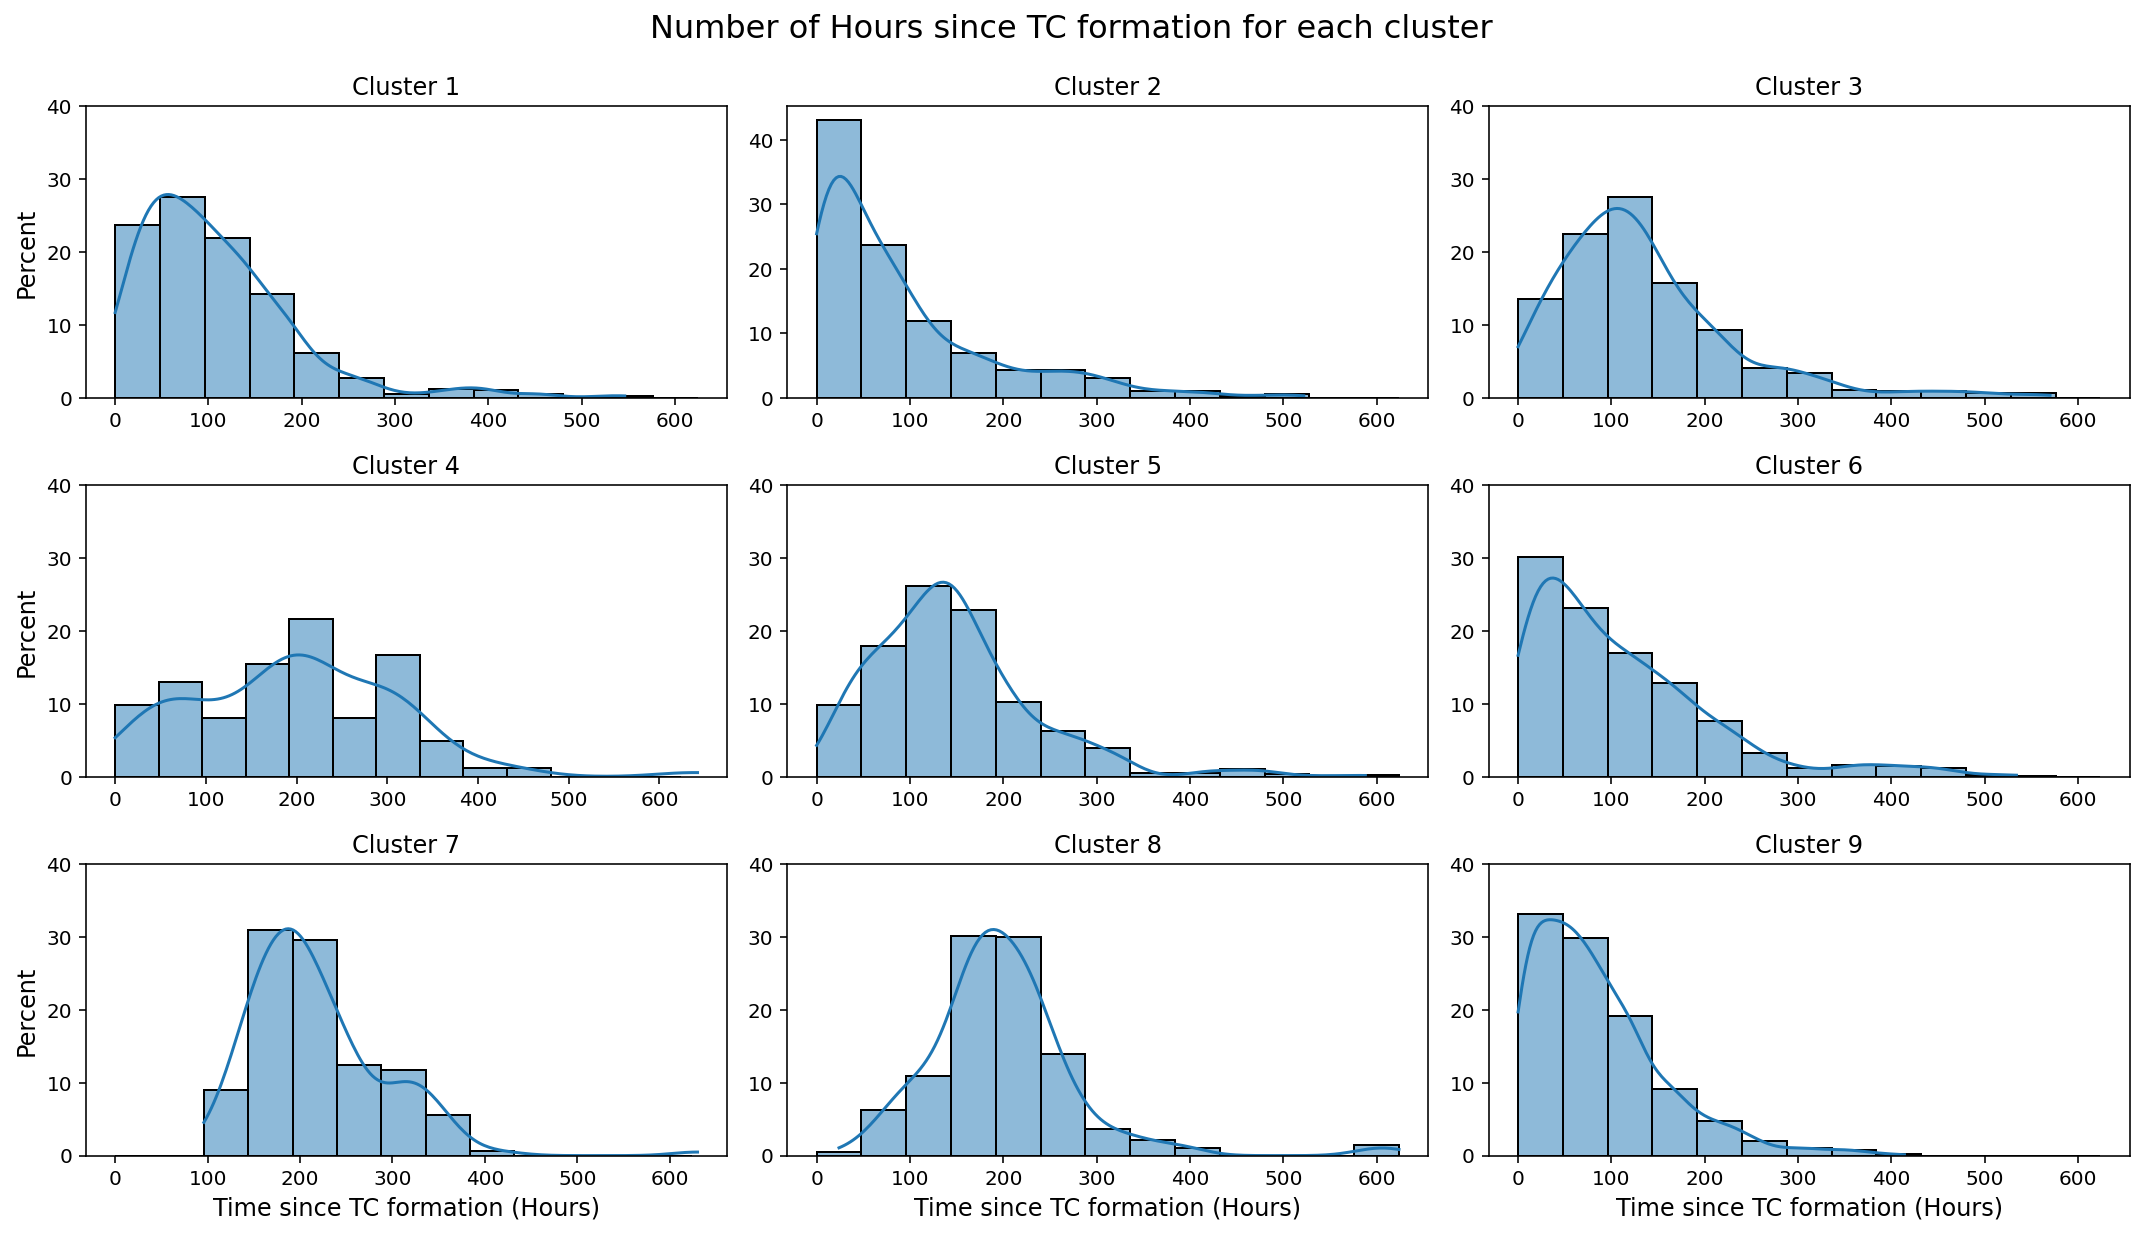

In [123]:
###########################################################
### Number of Hours since TC formation for each cluster ###
###########################################################
hour_hist=[[]]
for i in range(nodes-1):
    hour_hist.append([])
max=0
for i in range(len(storm_index[:,0])):
    for j in range(len(storm_index[0,:])):
        if np.isnan(storm_index[i,j])==False:
            ind = int(storm_index[i,j]) 
            hour_hist[ind].append(j*6)

bins = np.arange(0,672,48)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3))
ax = ax.ravel()

for i in range(nodes):    
    sns.histplot(hour_hist[i], bins=bins, kde=True, ax=ax[i],stat='percent')
    ax[i].set_title("Cluster "+str(i+1))
    ax[i].set_yticks(np.arange(0,41,10))
    if i > 5:
        ax[i].set_xlabel('Time since TC formation (Hours)', fontsize=12)
    ax[i].set(ylabel='')
    if i%3 == 0:
        ax[i].set_ylabel('Percent', fontsize=12)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.suptitle("Number of Hours since TC formation for each cluster",fontsize=16)

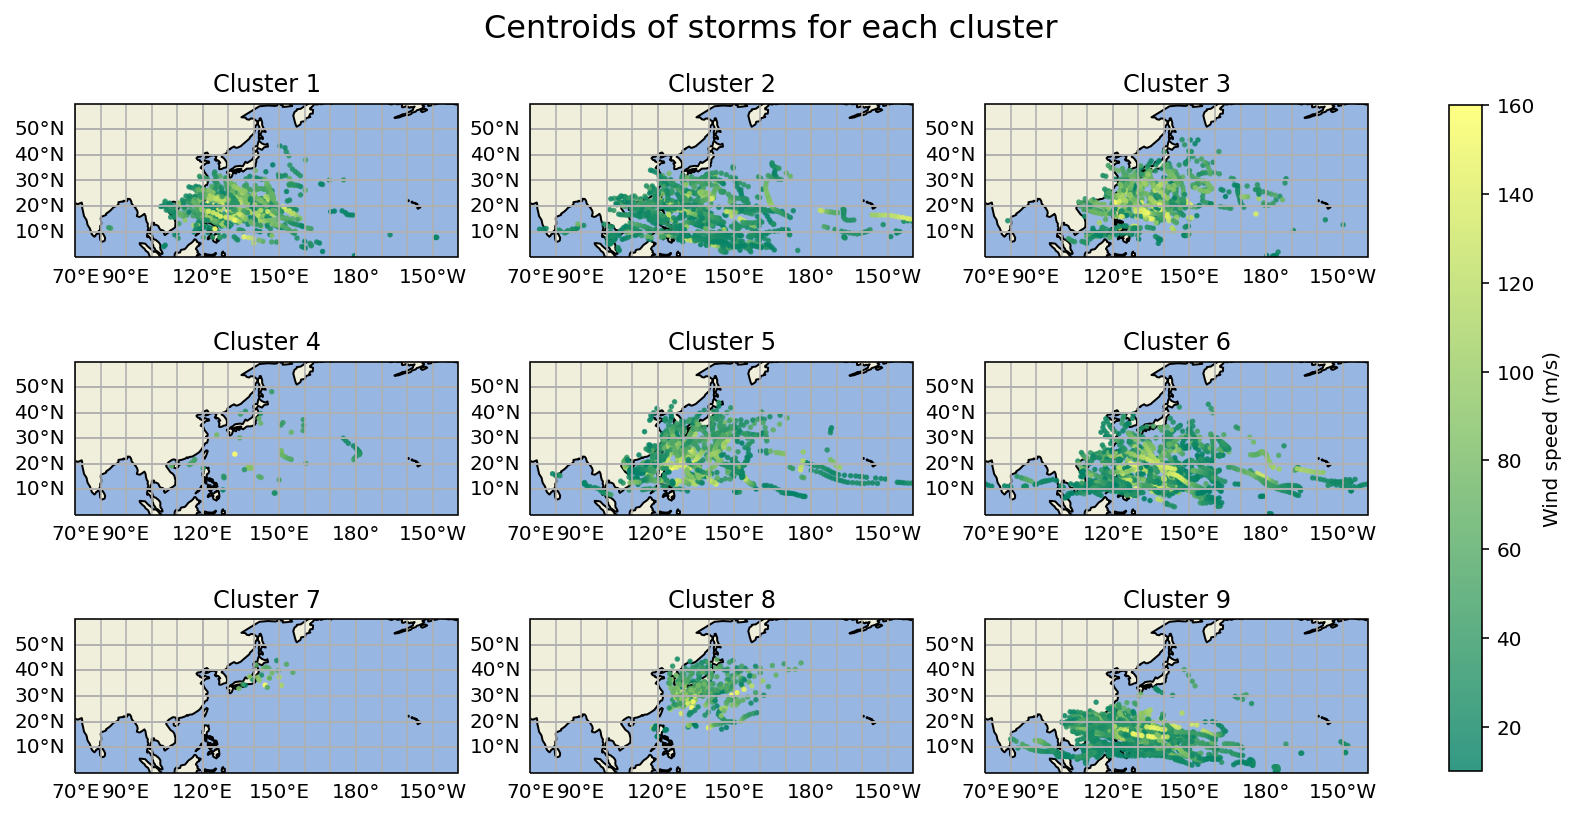

In [73]:
#####################################################################
### Chart for centroids of all the storms in each clusters (9213) ###
#####################################################################
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*2.5),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    im = ax[i].scatter(ds.longitude[cluster_index==i]-180, ds.latitude[cluster_index==i],
                       c=ds.usa_wind[cluster_index==i], cmap='summer',
                      s=3, alpha=0.8)
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(70-180,40)
    ax[i].set_ylim(0,60)
    ax[i].set_title("Cluster "+str(i+1))

    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10),
                         draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.suptitle('Centroids of storms for each cluster',fontsize=16,x=0.45)
fig.colorbar(im, ax=ax, shrink=0.92, label='Wind speed (m/s)')
plt.show()

Text(0.5, 1.0, 'Transition Chart 1')

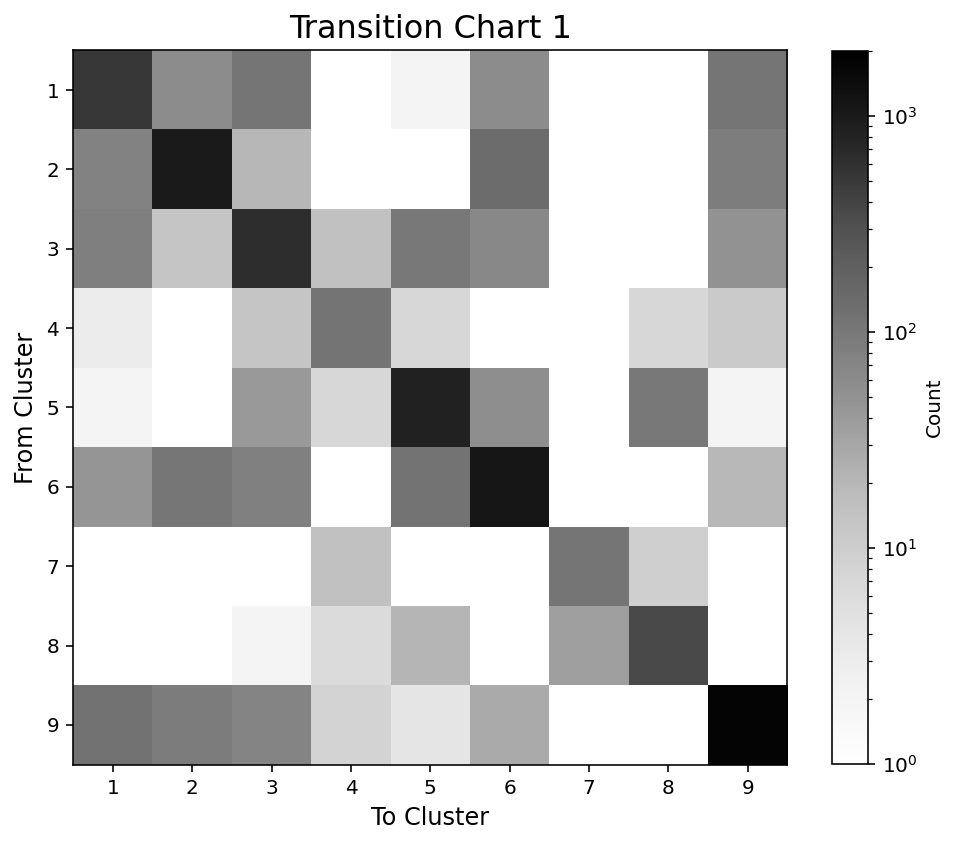

In [132]:
########################
### Transition table ###
########################
from matplotlib.colors import LogNorm

transition_table = np.zeros((nodes,nodes))
transition_lon=[[]]
transition_lat=[[]]
transition_wind=[[]]
transition_next=[[]]

for i in range(nodes-1):
    transition_lon.append([])
    transition_lat.append([])
    transition_wind.append([])
    transition_next.append([])

for i in range(278):
    for j in range(105):
        if np.isnan(storm_index[i,j])==False and np.isnan(storm_index[i,j+1])==False:
            transition_table[ int(storm_index[i,j]), int(storm_index[i,j+1]) ] += 1
            if storm_index[i,j]!=storm_index[i,j+1]:
                transition_lon[ int(storm_index[i,j]) ] .append(float(this_storm.lon[i,j]))
                transition_lat[ int(storm_index[i,j]) ] .append(float(this_storm.lat[i,j]))
                transition_wind[ int(storm_index[i,j]) ] .append(float(this_storm.usa_wind[i,j]))
                transition_next[ int(storm_index[i,j]) ] .append(storm_index[i,j+1])


fig, ax = plt.subplots(figsize=(8,8))
im = ax.matshow(transition_table,cmap='Greys', norm=LogNorm(vmin=1, vmax=2000))#, norm=LogNorm(vmin=0.001, vmax=100))
fig.colorbar(im, ax=ax, shrink=0.82, label='Count')
ax.set_xlabel('To Cluster', fontsize=12)
ax.set_xticks(np.arange(0,9),np.arange(1,10))
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('From Cluster', fontsize=12)
ax.set_yticks(np.arange(0,9),np.arange(1,10))
ax.set_title('Transition Chart 1', fontsize=16)

[[  0.  58. 106.   1.   2.  57.   0.   0. 106.]
 [ 76.   0.  20.   0.   0. 139.   0.   0.  87.]
 [ 81.  13.   0.  15.  97.  64.   0.   1.  49.]
 [  3.   0.  13.   0.   7.   0.   1.   7.  11.]
 [  2.   0.  41.   7.   0.  55.   0.  97.   2.]
 [ 46. 104.  80.   0. 113.   0.   0.   0.  19.]
 [  0.   0.   0.  15.   1.   0.   0.   9.   0.]
 [  0.   0.   2.   6.  21.   0.  36.   0.   0.]
 [117.  91.  71.   8.   4.  27.   0.   0.   0.]]


Text(0.5, 1.0, 'Transition Chart 2')

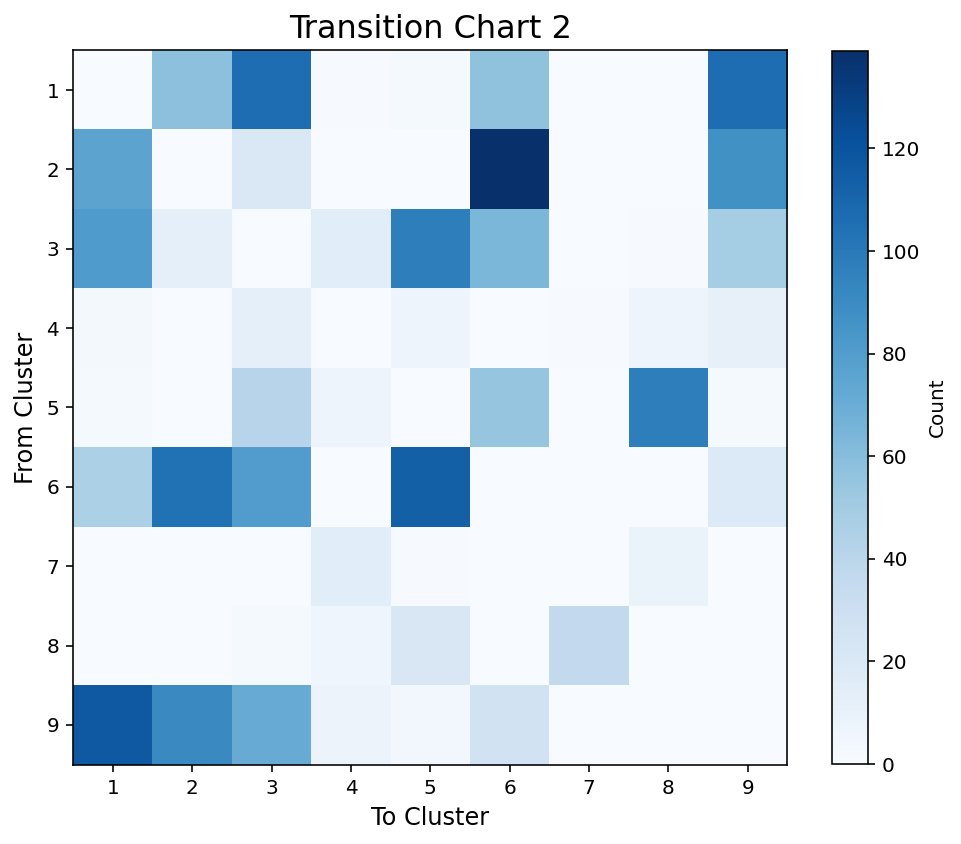

In [131]:
for i in range(nodes):
    transition_table[i,i] = 0
print(transition_table)

fig, ax = plt.subplots(figsize=(8,8))
im = ax.matshow(transition_table,cmap='Blues')#, norm=LogNorm(vmin=0.001, vmax=100))
fig.colorbar(im, ax=ax, shrink=0.82, label='Count')
ax.set_xlabel('To Cluster',  fontsize=12)
ax.set_xticks(np.arange(0,9),np.arange(1,10))
ax.set_ylabel('From Cluster', fontsize=12)
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks(np.arange(0,9),np.arange(1,10))
ax.set_title('Transition Chart 2', fontsize=16)

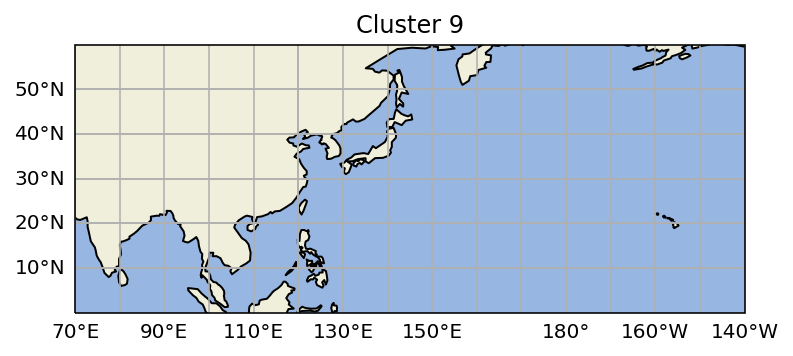

In [31]:
#[1,5], [0,8], [5,4], [0,2], [0,8], [2,4], [4,7], [1,8], [2,0], [5,2]
np.array(transition_lon[1])[np.array(transition_next[1])==5]
np.array(transition_lat[1])[np.array(transition_next[1])==5]
data = np.zeros_like(np.array(transition_lon[1])[np.array(transition_next[1])==5])
data+=1

usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(subplot_kw={'projection':usemap_proj})
sns.kdeplot(x=np.array(transition_lon[1])[np.array(transition_next[1])==4],
            y=np.array(transition_lat[1])[np.array(transition_next[1])==4],
           fill=True,shade=True,transform = ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines()
ax.set_xlim(70-180,40)
ax.set_ylim(0,60)
ax.set_title("Cluster "+str(i+1))

gl = ax.gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
gl.top_labels = False
gl.right_labels = False

Text(0.5, 0.98, 'Transition location')

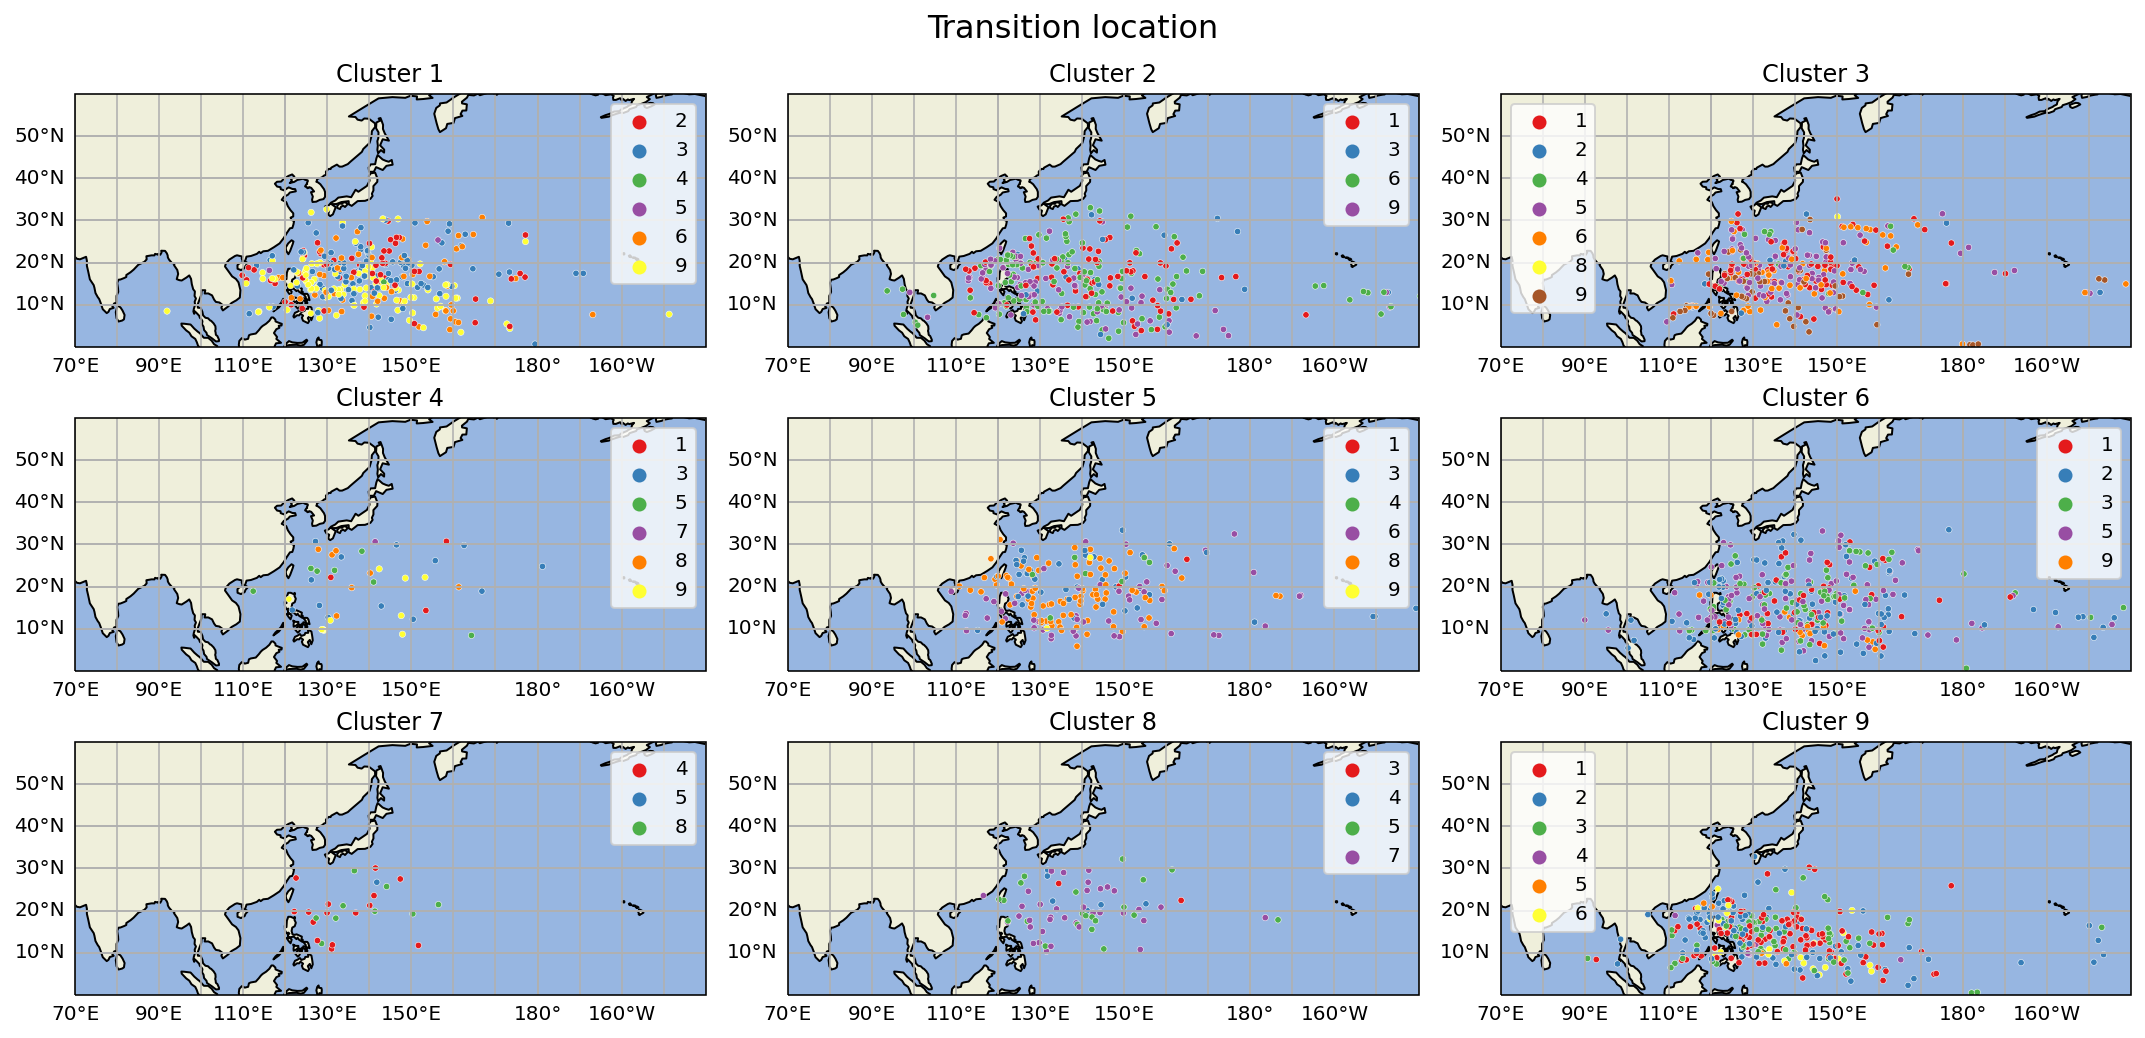

In [79]:
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*2.5),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
#     im = ax[i].scatter(np.array(transition_lon[i])-180, np.array(transition_lat[i]), c=transition_next[i], s=3,
#                       cmap='Set1')
    sns.scatterplot(x=np.array(transition_lon[i])-180, y=np.array(transition_lat[i]),
                    hue=np.array(transition_next[i]).astype(int)+1, s=10, palette='Set1', ax=ax[i], legend='brief')
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(70-180,40)
    ax[i].set_ylim(0,60)
    ax[i].set_title("Cluster "+str(i+1))

    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
            
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.suptitle('Transition location',fontsize=16)

In [33]:
mean_wind_change = np.zeros(nodes)
max_wind_change = np.zeros(nodes)
min_wind_change = np.zeros(nodes)
for i in range(nodes):
    mean_wind_change[i] = np.nanmean(wind_change24[storm_index==i])
    max_wind_change[i] = np.nanmax(wind_change24[storm_index==i])
    min_wind_change[i] = np.nanmin(wind_change24[storm_index==i])
    
mean_pres_change = np.zeros(nodes)
max_pres_change = np.zeros(nodes)
min_pres_change = np.zeros(nodes)
for i in range(nodes):
    mean_pres_change[i] = np.nanmean(pres_change24[storm_index==i])
    max_pres_change[i] = np.nanmax(pres_change24[storm_index==i])
    min_pres_change[i] = np.nanmin(pres_change24[storm_index==i])
    
mean_lat_change = np.zeros(nodes)
max_lat_change = np.zeros(nodes)
min_lat_change = np.zeros(nodes)
for i in range(nodes):
    mean_lat_change[i] = np.nanmean(lat_change24[storm_index==i])
    max_lat_change[i] = np.nanmax(lat_change24[storm_index==i])
    min_lat_change[i] = np.nanmin(lat_change24[storm_index==i])

In [34]:
# import openpyxl
# stats = pd.DataFrame((mean_wind_change,max_wind_change,min_wind_change, 
#               mean_pres_change,max_pres_change,min_pres_change, 
#               mean_lat_change,max_lat_change,min_lat_change),
#             columns=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'],
#             index=['Mean change','Max change','Min change','Mean change','Max change','Min change',
#                    'Mean change','Max change','Min change',]).T
# stats.to_excel('stats.xlsx')

In [35]:
fixed_loni = np.arange(100,181)
fixed_lati = np.arange(0,51)

fixed_u_shear = ds2.fixed_u_200-ds2.fixed_u_850
fixed_v_shear = ds2.fixed_v_200-ds2.fixed_v_850
fixed_total_shear = np.sqrt(fixed_u_shear.sel(longitude=fixed_loni, latitude=fixed_lati)**2 +
                            fixed_v_shear.sel(longitude=fixed_loni, latitude=fixed_lati)**2)
#np.mean(ds2.fixed_gh_200.sel(longitude=fixed_loni,latitude=fixed_lati)[cluster_index==i], axis=0)
fixed_wind_850 = np.sqrt(ds2.fixed_u_850**2+ds2.fixed_v_850**2).sel(longitude=fixed_loni,latitude=fixed_lati)
fixed_wind_500 = np.sqrt(ds2.fixed_u_500**2+ds2.fixed_v_500**2).sel(longitude=fixed_loni,latitude=fixed_lati)
fixed_wind_200 = np.sqrt(ds2.fixed_u_200**2+ds2.fixed_v_200**2).sel(longitude=fixed_loni,latitude=fixed_lati)

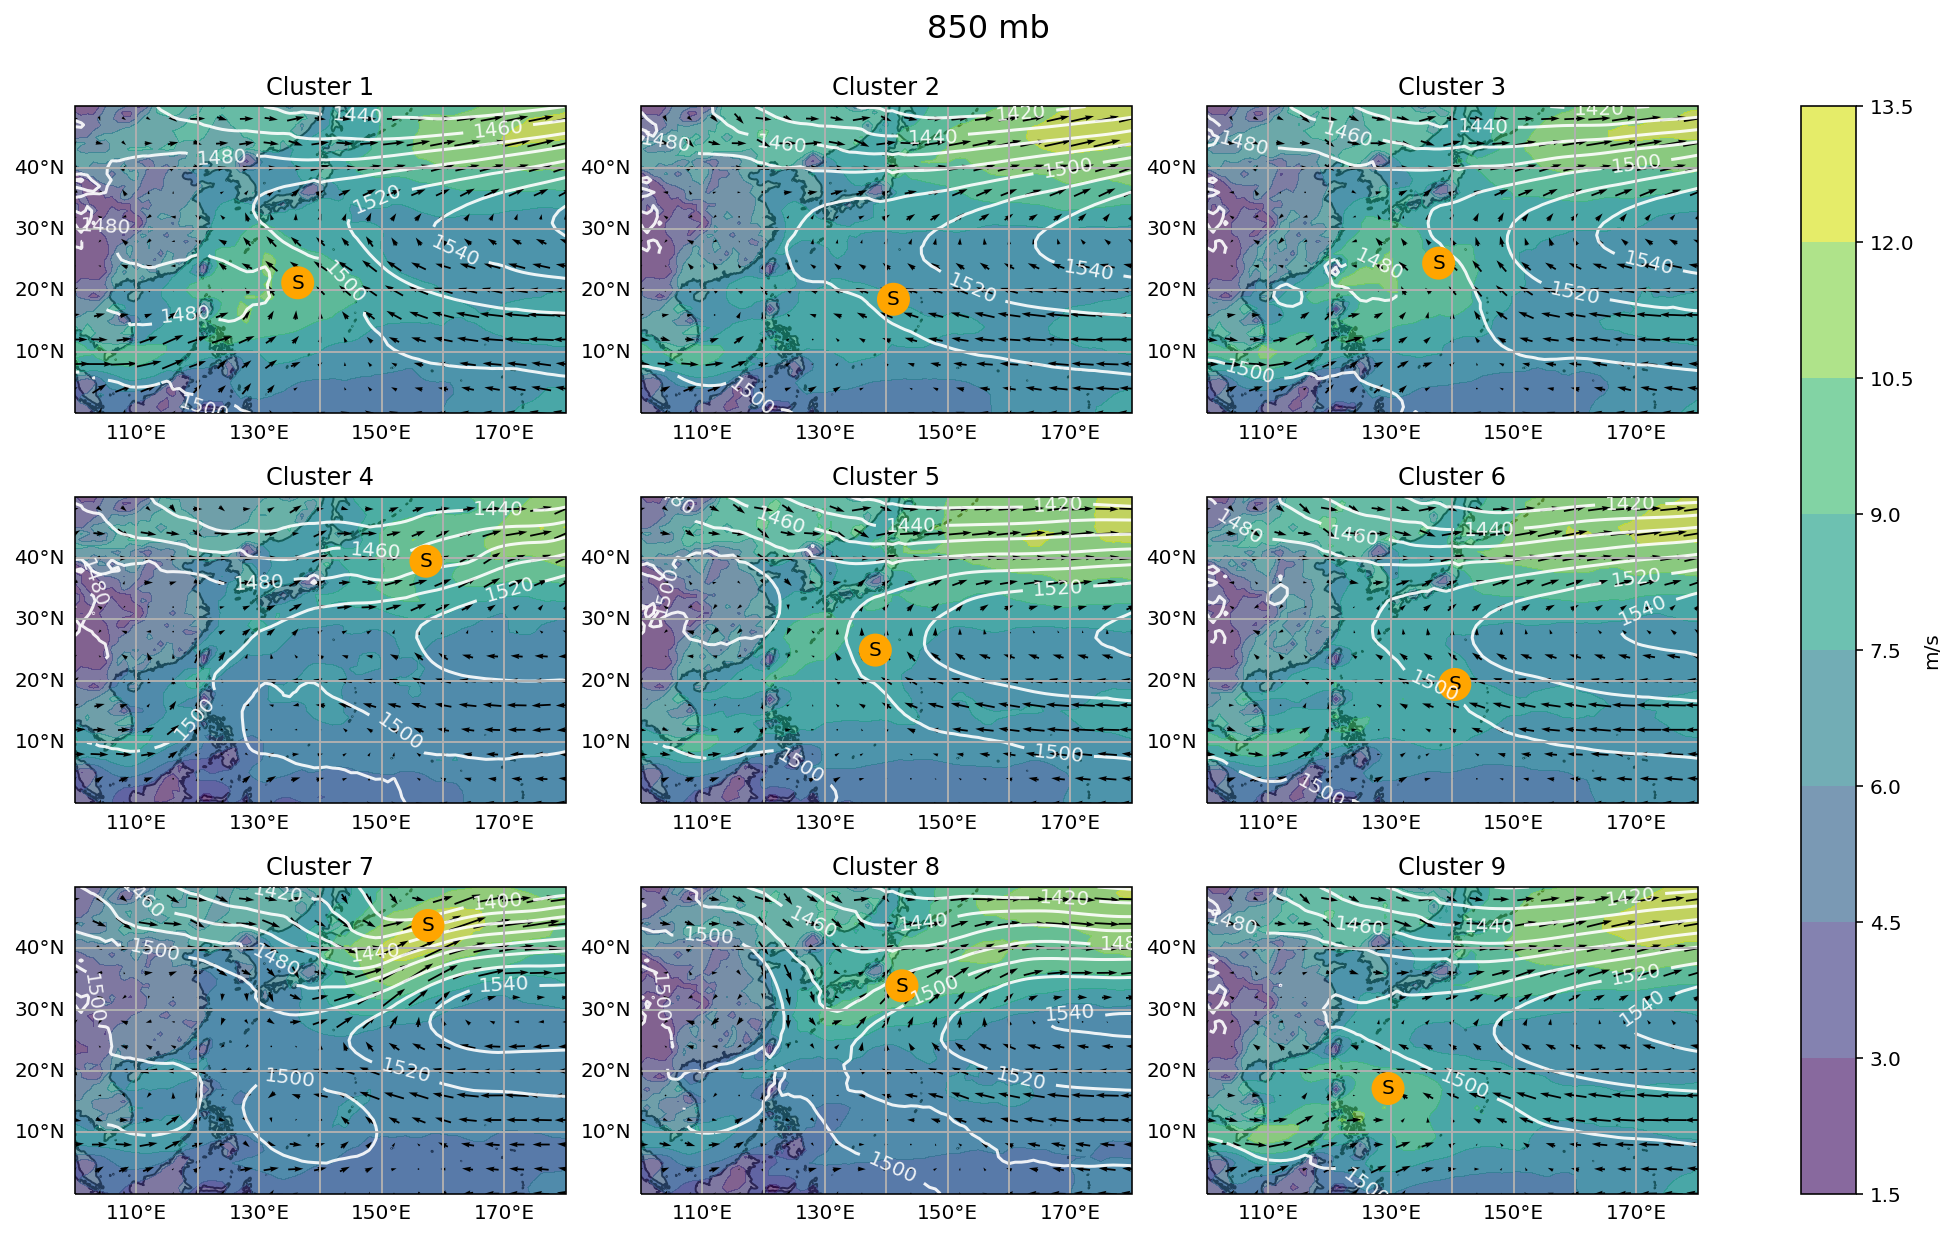

In [78]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    ghi = np.mean(ds2.fixed_gh_850.sel(longitude=fixed_loni,latitude=fixed_lati)[cluster_index==i], axis=0)
    
    im1 = ax[i].contour(fixed_loni-180, fixed_lati, 
                        ghi.where(ghi>topo.values),
                        alpha=0.9, colors='white', levels=np.arange(1400,1600,20))
    ax[i].clabel(im1, inline=True, fontsize=10)
    
    im = ax[i].contourf(fixed_loni-180, fixed_lati, 
                        np.mean(fixed_wind_850[cluster_index==i], axis=0),# levels=np.arange(10,20,0.01),
                        alpha=0.65)
    
#     im = ax[i].contourf(fixed_loni-180, fixed_lati, 
#                         np.mean(ds2.fixed_gh_200[cluster_index==i], axis=0),
#                         alpha=0.8)
    ax[i].text(np.mean(ds.longitude[cluster_index==i]-180), np.mean(ds.latitude[cluster_index==i]), "S",bbox=dict(boxstyle="circle",color="Orange"))
    Q = ax[i].quiver((fixed_loni-180)[::4], fixed_lati[::4], 
                     np.mean(ds2.fixed_u_850.sel(longitude=fixed_loni, latitude=fixed_lati)[cluster_index==i], axis=0)[::4,::4],
                     np.mean(ds2.fixed_v_850.sel(longitude=fixed_loni, latitude=fixed_lati)[cluster_index==i], axis=0)[::4,::4], 
                     pivot='mid', scale=1/0.0075)

    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(-80,0)
    ax[i].set_ylim(0,50)
    ax[i].set_title("Cluster "+str(i+1))
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.colorbar(im, ax=ax.ravel().tolist(), label='m/s')
fig.suptitle('850 mb',fontsize=16,x=0.47)
plt.show()

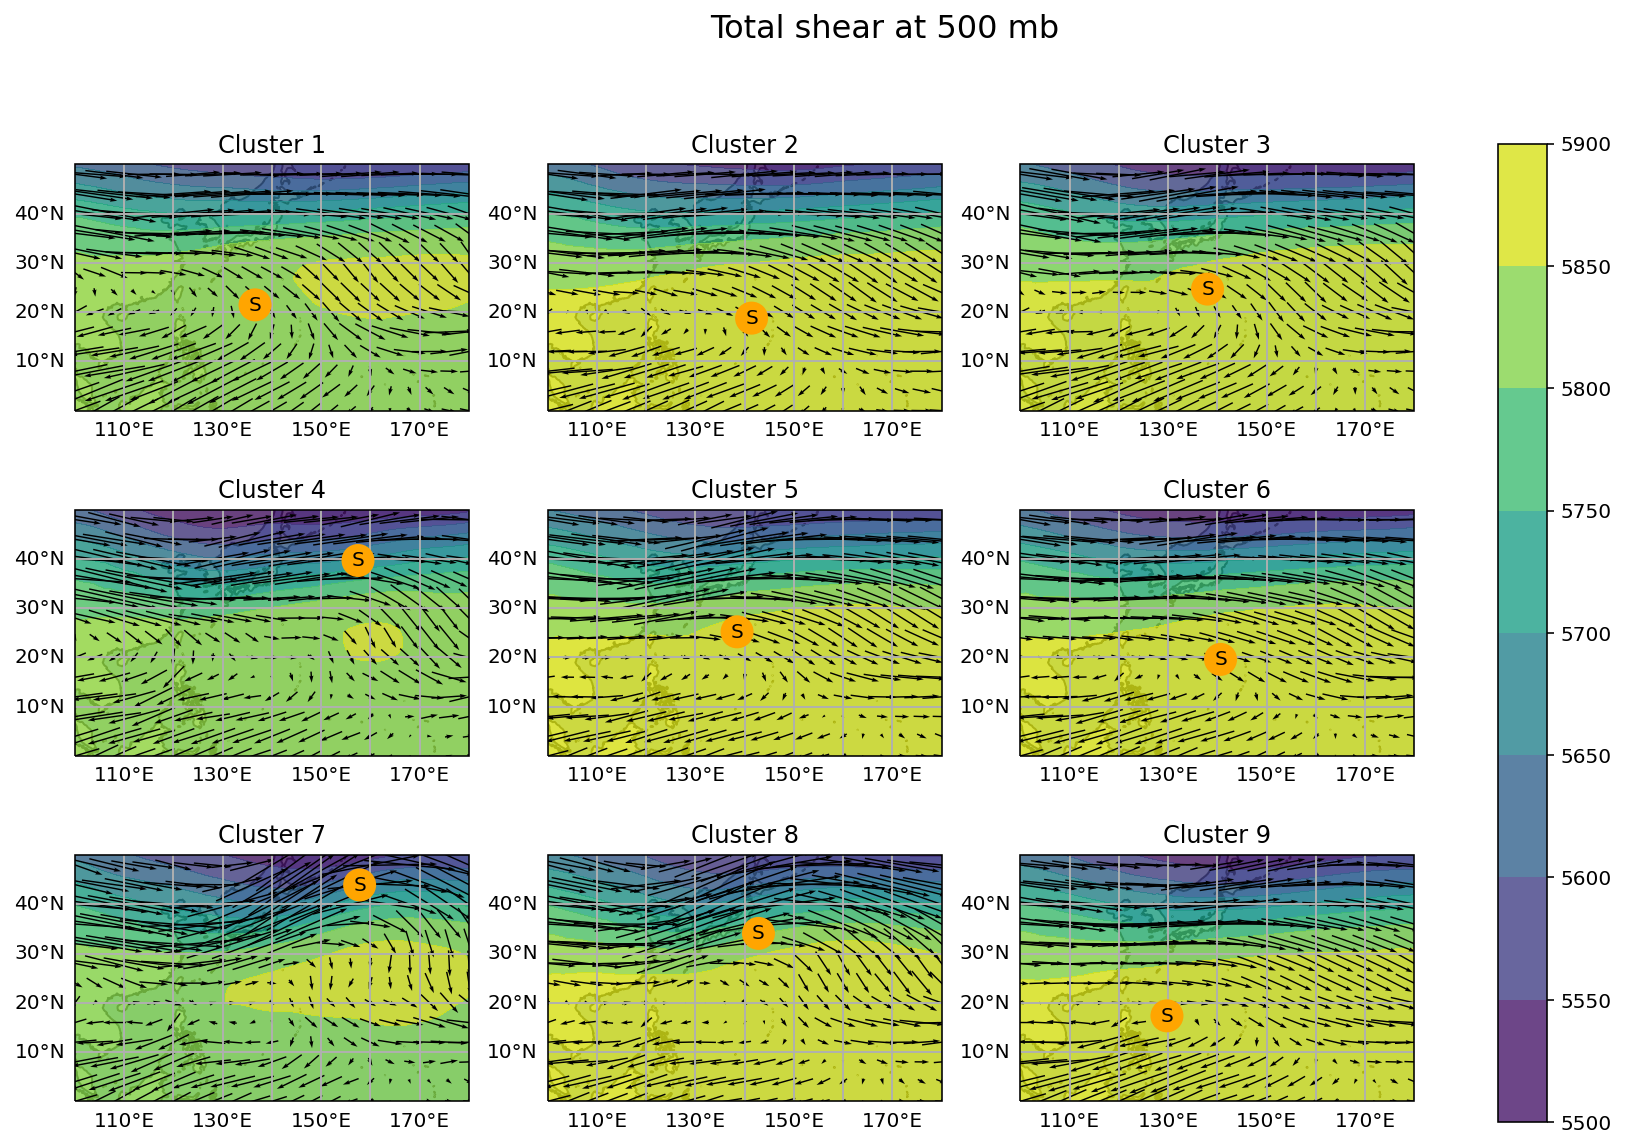

In [37]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)

    #patterni = np.reshape(np.mean(z_norm_total_shear[cluster_index==i],axis=0),(61,61))
    
    im = ax[i].contourf(fixed_loni-180, fixed_lati, 
                        np.mean(ds2.fixed_gh_500[cluster_index==i], axis=0)
                        .sel(longitude=fixed_loni,latitude=fixed_lati),alpha=0.8)
    
    ax[i].text(np.mean(ds.longitude[cluster_index==i]-180), np.mean(ds.latitude[cluster_index==i]), "S",bbox=dict(boxstyle="circle",color="Orange"))
    Q = ax[i].quiver((fixed_loni-180)[::4], fixed_lati[::4], 
                     np.mean(fixed_u_shear.sel(longitude=fixed_loni, latitude=fixed_lati)[cluster_index==i], axis=0)[::4,::4],
                     np.mean(fixed_v_shear.sel(longitude=fixed_loni, latitude=fixed_lati)[cluster_index==i], axis=0)[::4,::4], 
                     pivot='mid', scale=1/0.0075)

    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(-80,0)
    ax[i].set_ylim(0,50)
    ax[i].set_title("Cluster "+str(i+1))
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
#fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('Total shear at 500 mb',fontsize=16)
plt.show()

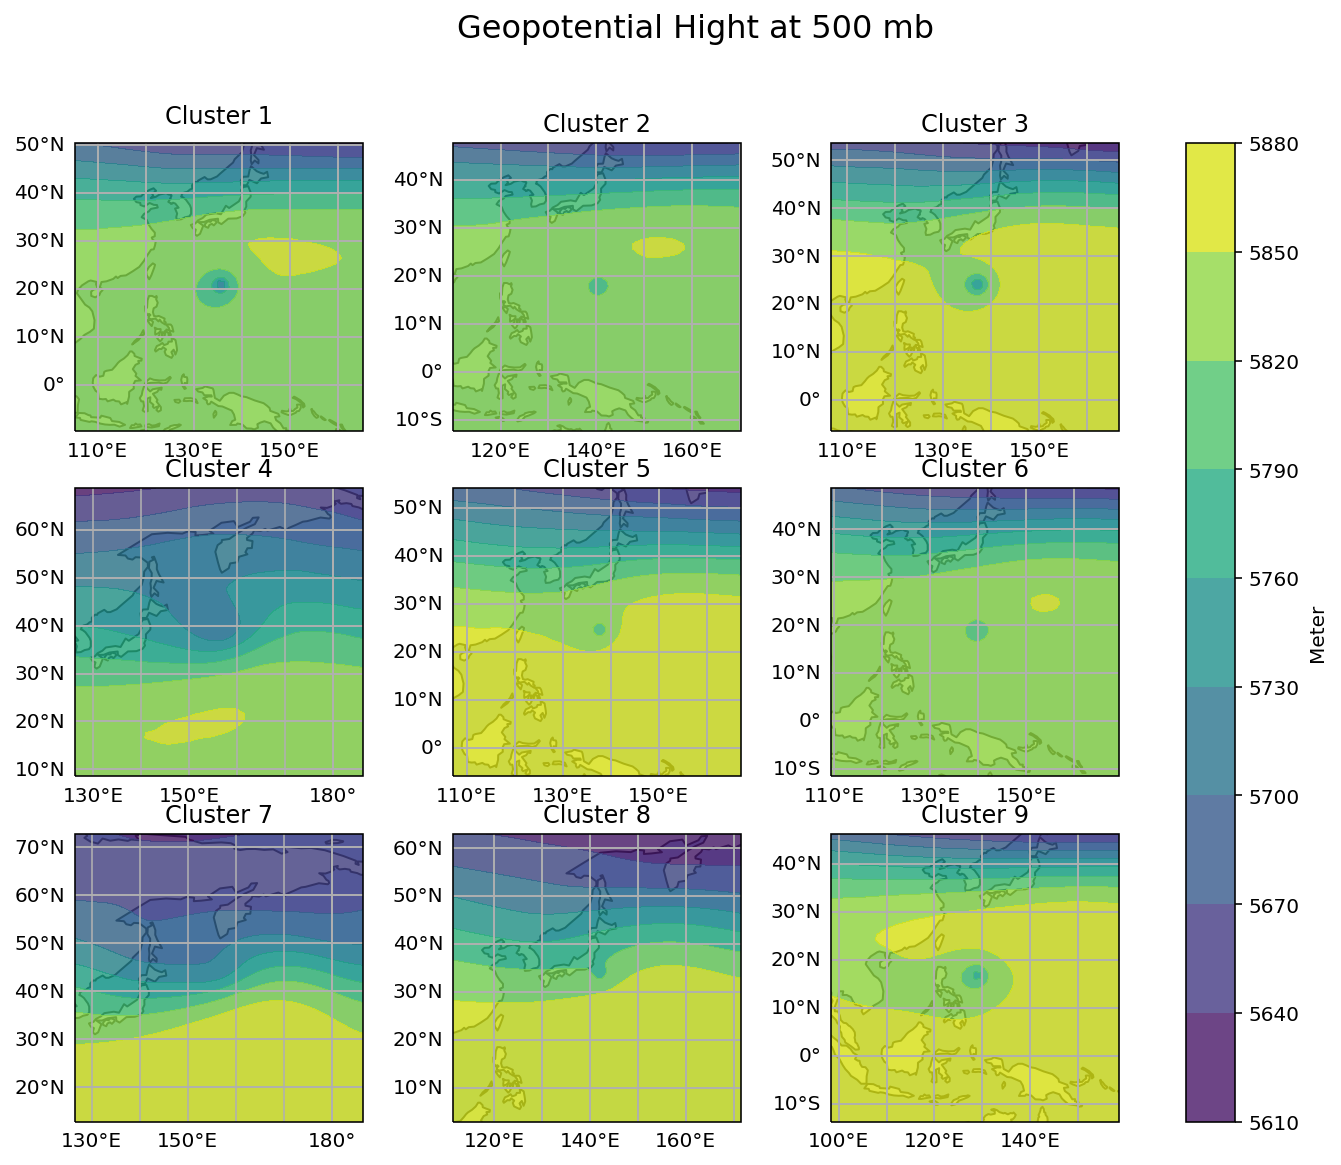

In [38]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    im = ax[i].contourf(loni-180, lati, np.mean(ds.gh_500[cluster_index == i], axis=0),alpha=0.8)
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
        
fig.colorbar(im, ax=ax.ravel().tolist(),label='Meter')
fig.suptitle('Geopotential Hight at 500 mb',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees
### Colorbar and cmap different

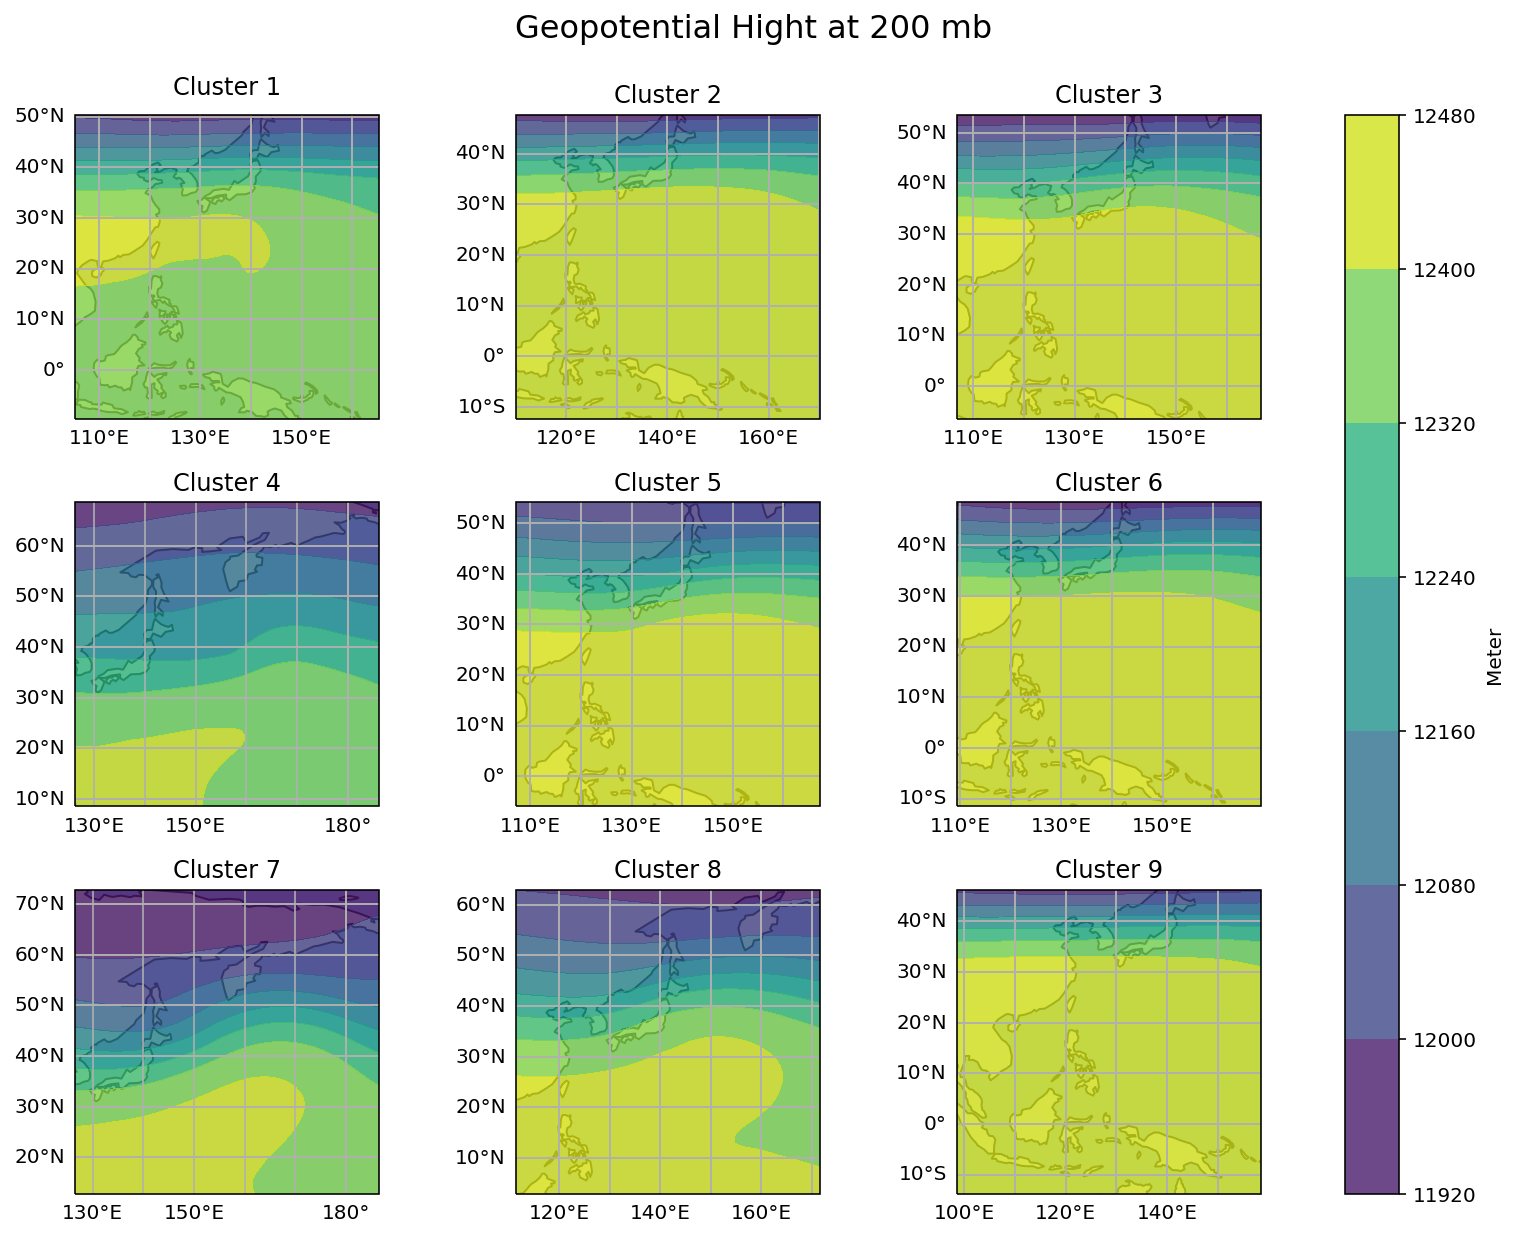

In [39]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    im = ax[i].contourf(loni-180, lati, np.mean(ds.gh_200[cluster_index == i], axis=0),alpha=0.8)
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.colorbar(im, ax=ax.ravel().tolist(),label='Meter')
fig.suptitle('Geopotential Hight at 200 mb',fontsize=16)
plt.show()

In [41]:
pulse

NameError: name 'pulse' is not defined

In [ ]:
############################
##### RELATIVE EXAMPLE #####
############################

#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    im = ax[i].contourf(loni-180, lati, np.mean(ds.gh_200[cluster_index == i], axis=0),alpha=0.8)
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig.colorbar(im, ax=ax.ravel().tolist(),label='Meter')
fig.suptitle('Geopotential Hight at 200 mb',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees
### Colorbar and cmap different

In [ ]:
# Sklearn normalization, (I don't think it's Min-Max normalization)
skl_norm_u_shear = preprocessing.normalize(u_shear_reshape)
print(skl_norm_u_shear)

In [ ]:
som = MiniSom(3, 5, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(skl_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(skl_norm_u_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(skl_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(skl_norm_u_shear)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
# Min-max normalization
min_max_norm_u_shear = (u_shear_reshape-np.min(u_shear_reshape)) / (np.max(u_shear_reshape)-np.min(u_shear_reshape))

In [ ]:
som = MiniSom(5, 7, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(min_max_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(min_max_norm_u_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(min_max_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(min_max_norm_u_shear)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
# gh_200 min_max normalization
gh_200_reshape=np.reshape(np.array(ds.gh_200),(9213,3721))
min_max_norm_gh_200 = (gh_200_reshape-np.min(gh_200_reshape)) / (np.max(gh_200_reshape)-np.min(gh_200_reshape))

In [ ]:
som = MiniSom(15, 15, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(min_max_norm_gh_200)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(min_max_norm_gh_200, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(min_max_norm_gh_200)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(min_max_norm_gh_200)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(min_max_norm_gh_200):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
#     plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
#              markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

In [ ]:
# each neuron represents a cluster
som_shape = (15,15)
winner_coordinates = np.array([som.winner(x) for x in min_max_norm_gh_200]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
(cluster_index)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(min_max_norm_gh_200[cluster_index == c, 0],
                min_max_norm_gh_200[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

In [ ]:
W = som.get_weights()
plt.figure(figsize=(5, 5))
for i in range(W.shape[2]):
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
#     plt.xticks(np.arange(size+1))
#     plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

In [ ]:
som = MiniSom(15, 15, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(z_norm_total_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(z_norm_total_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(z_norm_total_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
W = som.get_weights()
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
#     plt.xticks(np.arange(size+1))
#     plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()